<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P0C1S1/sequences/P0C1_Introduction/P0C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **0.1.1: Evolution and Learning as Nested Optimization Processes**
A central theme in our book is that learning processes and structures in the brain are targets of evolution. This is a short sequence of interactive exercises and simulations showing how this can work. We use simple, concrete examples to anchor and illustrate this core concept.
### Objective: See how learning and evolution can act as optimization processes, shaping an organism's behaviour to better fit an ecological niche.

In this sequence we will:

* Introduce a basic eat-don't-eat binary discrimination task, which defines the ecological niche of a very simple organism.

* Implement an agent based simulation of a process of natural selection acting on inherited variation. In this first simulation, evolution selects the behavioural policy of the organism (a.k.a. its stimuli-behaviour response function) directly. This shows how a propose-accept-reject type of optimization algorithm, roughly what evolution by natural selection does, can discover a good solution behavioural policy over many generations. In this simulation the behavioural policy is specified by inherited parameters, so individuals with the same 'genotype' will express the same behaviours regardless of their past experiences.

* See how this evolutionary process responds to shifts in environment, i.e. what happens when the right kind of thing to eat changes? How long does it take for the population to adapt to the change in ecological niche?

* Extend the evolutionary simulation so that now organisms also use reward based learning to improve their behavioural policy within their lifetime. Compare the performance of this 'learning' organism with the fixed behaviour function organism for different rates of environmental change. See how this helps with resiliance. Change is the only constant

* Further extend the evolutionary model so that the learning rule itself is also a target of evolution (just learning rate or other parameters?). Again compare how quickly the population adapts to changes in ecological niche.

* Extend the model yet further allowing the structure of the behaviour generating function to also be a target of evolution. Yet again compare how quickly the population adapts to changes in ecological niche.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @markdown **Dependencies, Imports and Setup:** You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pygraphviz as pgv
import ipywidgets as widgets
import time
import os
import copy
import tensorflow_datasets as tfds
from io import BytesIO
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from tqdm.notebook import tqdm

class DotDict(dict):
  def __getattr__(self, item):
    try:
      return self[item]
    except KeyError:
      raise AttributeError(f"'DotDict' object has no attribute '{item}'")

  def __setattr__(self, key, value):
    self[key] = value

  def __delattr__(self, item):
    try:
      del self[item]
    except KeyError:
      raise AttributeError(f"'DotDict' object has no attribute '{item}'")

# Load the MNIST dataset as numpy arrays
ds, ds_info = tfds.load('mnist', split='train', batch_size=-1, as_supervised=True, with_info=True)
images, labels = tfds.as_numpy(ds)  # Convert to numpy arrays
images = images.astype(np.float32) / 255.0
# grab the 1's and 0's and augment
X = np.squeeze(images)
y = labels
bin_idx = (y==0) | (y==1)
y_bin = y[bin_idx]
X_bin = X[bin_idx]

def augment_image(image):
  # Rotate the image for 0, 90, 180, and 270 degrees
  rotations = [np.rot90(image, k=i) for i in range(4)]
  # Apply horizontal flip to each rotated image
  flips = [np.fliplr(rot) for rot in rotations]
  # Return all augmented images
  return rotations + flips
# Apply augmentation
augmented_images = [augment_image(img) for img in X_bin]
# Flatten the list of lists
augmented_images = [img for sublist in augmented_images for img in sublist]
# Convert to flattened
X_bin_aug = np.array(augmented_images).reshape(-1, 28*28)
# Augment labels accordingly
y_bin_aug = np.repeat(y_bin, 8)  # Each image now has 8 versions
ones_column = np.ones((X_bin_aug.shape[0], 1))  # Create a column of ones, with the same number of rows as X_bin_aug
X_bin_aug1 = np.hstack((X_bin_aug, ones_column))  # Concatenate the column of ones to X_bin_aug horizontally

# supress some matplotlib warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

# set up plotting style
import logging
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()

# set up feedback widget
def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P0C1_S1"

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Running in colab


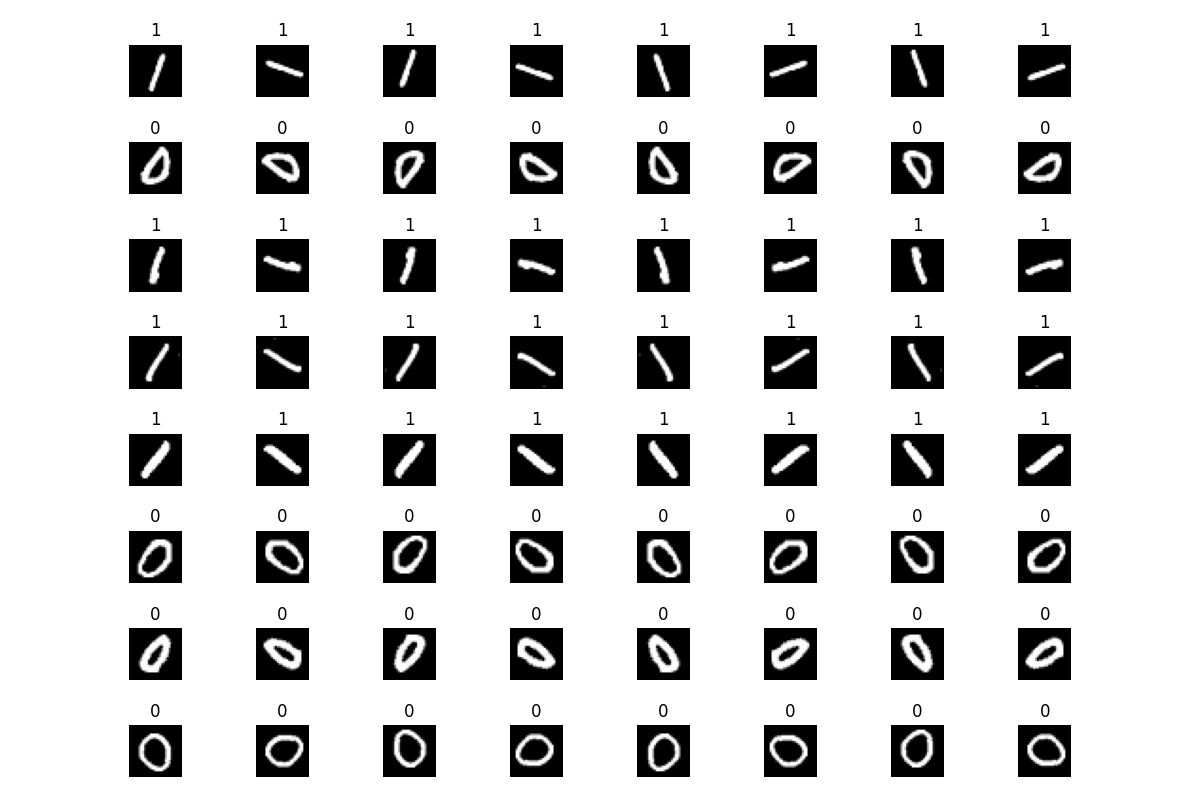

In [2]:
num_images = 64
rows = 8
cols = int(num_images / rows)
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))  # Set up a row of 10 subplots
for r_ in range(rows):
  for c_ in range(cols):
    ax = axes[r_, c_]
    ax.imshow(X_bin_aug1[r_*cols + c_][:784].reshape(28, 28), cmap='gray')  # Ensure using the right colormap if needed
    ax.axis('off')  # Hide axes for clarity
    ax.set_title(str(y_bin_aug[r_*cols + c_]), fontsize=12)  # Use set_title to display the label below each image
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

# 0.1.1.1: To Eat Or Not To Eat, That is The Question



## Life History Picture

In this sequence we consider the life and evolution of a population of cartoonishly simple organisms. The life cycle of this organism is dominated almost entirely by the simple binay decision problem illustrated and described below.

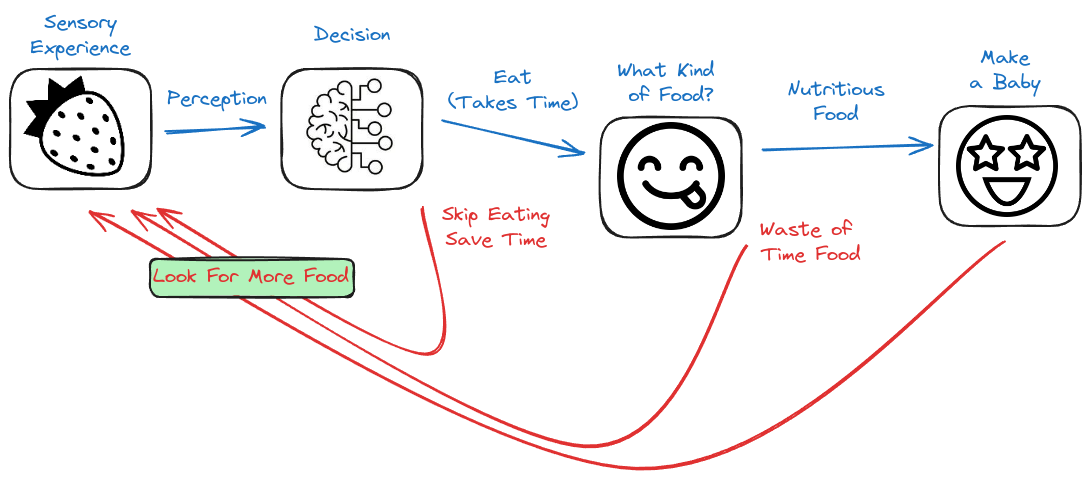

In this simulation an organism's life consist of a series of episodes. Each episode is initiated by the seneory experience of something that the organism might eat. Based on this sensory experience the organism has to make a decision: approach and eat the food, which will take some time and effort; or skip eating and save some time and effort. If the organism skips eating, then the episode ends after the organism has spent only one time unit (percieving and deciding takes one time unit) of their precisous life on this episode. Alternatively if they choose to approach and eat, they spend an additional time unit of life, and get have another sensory experience, this time the taste of the thing that they tried to eat. If the food was nutritous, they become more fat and happy and are thus more likely to have spawn offspring that survive into the next generation of the population. If though, the food is not nutritious, they have now wasted a total of two time units of their short sweet precious time alive (one unit percieving and deciding to approach, one unit approaching and tasting) and they are no more likely to have progeny for their effort.

That describes the core activity of the organisms in their niche, now let's describe the rest of their life history. Each generation, every organism lives for exactly 200 time units, at which point they die. The ecological niche where this population lives can support a maximum of 100 individuals. All of the babies born in the previour generation compete to become one of the 100 adults in the next generation. Children mostly resemble their parents. Specifically, how organisms approach the binary discrimination problem described above will depend on a number of real valued parameters (exactly how to be discussed shortly). Children will have the same parameter values as their parents, perturbed by Gaussian noise. Note there is no model here of the specific process of genetic inheritence and development, Gaussian noise on parameters is a rough substitute for explicitly modeled mechanisms of inheritence and development, serving as a kind of rug thrown over the complexity of the interactions between genes, how they change through point-mutations and recombination, and how these changes affect behavioural phenotype through a developmental process.



___
## Pedagogy Note: Simple Problems

Throughout this book we will typically ground our discussion in the simplest possible 'toy problems'. Problems are selected for there didactic value, not their realism, because they definatively prove something, or because they make a good prediction or description of some empirical phenomena. However, in the final chapters of the book as a kind of proof of principles we show how the core concepts introduced throughout the book can be complexified along two axis of biological plausibility, 1) alignment with known electro-physiology, 2) ability to solve the challenging learning problems like those encountered by real organisms. These more complex models are less useful for understanding principles, which is why they come at the end, but potentially much more useful in describing and predicting data in an empirical settings.
___

## Interaction: Trying Out Eat Don't Eat

In [3]:
# @markdown **Run this cell** to try out the 'eat-don't-eat' discrimination task faced by the organisms in our simulation.

class InteractiveMNISTPredator():
  def __init__(self,
               features=X_bin_aug1,
               labels=y_bin_aug,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 785 (reshape to 28x28 plus bias for display)
    # labels is num_data_points x 1 (values 0/1)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    self.time_spent = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description="Eat")
    self.no_strike_button = widgets.Button(description="Don't Eat")
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.feedback_display,
                                                         self.score_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 785:
        image = image[:784].reshape(28,28)
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray')
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision("Eat")

  def on_no_strike_clicked(self, button):
    self.process_decision("Don't Eat")

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    should_eat = self.labels[self.current_index] == 1
    correct_string = "nutritious, you make a baby!" if should_eat else 'a waste of time, no baby today.'
    if decision == "Eat":
      self.time_spent += 2
      if should_eat:
        self.successful_strikes += 1
      else:
        self.failed_strikes += 1
    elif decision == "Don't Eat":
      self.time_spent += 1
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == "Eat")):
      # Show informative feedback
      feedback = f'You spent some time eating. The food you ate was {correct_string}'
    else:
      # Show uninformative feedback
      feedback = "You didn't eat, moving on to the next thing."
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Time Spent Searching: {self.current_index + 1}')
      print(f'Time Spent Eating: {self.failed_strikes + self.successful_strikes}')
      print(f'Total Time Spent: {self.time_spent}')
      print(f'Babies Made: {self.successful_strikes}')
      print(f'Babies Made per Time Spent: {(self.successful_strikes/self.time_spent):.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


bin_imp = InteractiveMNISTPredator(features=X_bin_aug1,
                                           labels=y_bin_aug, feedback_type='on_strike_only')
display(bin_imp.fig.canvas)
clear_output()
display(bin_imp.ui)

Were you able to detect a pattern? You may have noticed that the things you should eat look like sticks and the the things that are as waste of time looked a bit like circles or ovals. Now that we have a sense of what the core decision problem for the organism is, let's take a look at how the decision function works.

## Decision as Computation

In more detail the task these organisms face is to take the inputs from their 28x28 receptive field, and based on this decide whether to approach the food and try to eat it, or leave that potential food and start searching for the next thing to eat. Approaching and attempting to eat food takes time, so trying to eat things that are not nutritious wastes time, and leads to reduced reproduction. If we want to simulate an evolutionary process centered around this decision problem we first need to specify the nature of the behavioural policy, denoted $\pi$ (for policy).

We model this organism's behavioural policy as follows. We let $\mathbf{x}$ be the raw (visual) sensory input (column vector) of length 784 in a given episode. (This can be reshaped into the $28\times28$ receptive field we saw in the example.) We can think of each element $x_i$ of $\mathbf{x}$ as corresponding to the activation level of a single photosensitive neuron.

These input neurons are then connected to two output neurons, each one corresponding one of the two possible action selections, "eat" or "don't eat".

The activation level, as a vector $\mathbf{z}$, of these output neurons is computed as
$$ \mathbf{h} = \sigma(\mathbf{W}^1\mathbf{x}) $$
$$\mathbf{z} = \mathbf{W}^{\text{s}}\mathbf{x} + \mathbf{W}^2 \mathbf{h}$$
Here $\mathbf{h}$ is the activity of an intermediate layer of neurons, $\sigma$ is the standard logistic sigmoid function applied elementwise. This non-linearity allows for greater computationally flexibility in the behaviour function. $\mathbf{W}^1$, $\mathbf{W}^{\text{s}}$, and $\mathbf{W}^2$ are matrices of synaptic weights between the input neurons and the intermediate nuerons, the input neurons and the output neurons, and the intermediate neurons and the output neurons respectively. In this case where there are 785 inputs (we have done a standard 'trick' of augmenting $\mathbf{x}$ with a feature of contant value, hence 785 inputs instead of 784 which allows for a parameterizable baseline level of activation independent of sensory input) and 3 intermediate neurons, and 2 outputs, so $\mathbf{W}^1$ has shape $3 \times 785$, $\mathbf{W}^\text{s}$ has shape $2 \times 785$ and $\mathbf{W}^3$ has shape $2 \times 3$. This gives us
$$ h_i = \sigma \left( \sum_{j=1}^{785} w^1_{ij} x_j \right)$$
and
$$ z_i = \sum_{j=1}^{785} w^\text{s}_{ij} x_j + \sum_{j=1}^{3} w^2_{ij} h_j$$

**Notation Note**: $w_{ij}$ is the weight connecting the $j^{th}$ input to the $i^{th}$ output and is the element in the $i^{th}$ row and $j^{th}$ column of $\mathbf{W}$. Superscripts on $\mathbf{W}$ and $w$ indicate the specific layer of connections, $1^{st}$, $2^{nd}$ or skip.

To convert these activation levels, $\mathbf{z}$, into probabilities of taking actions we use softmax normalization. Softmax can be thought of as an extension of the logistic sigmoid function to multiple classes. (Even though we only have two classes here and we could use a logistic sigmoid function, mathematically and conceptually things work out more cleanly when we use the softmax function). Much like the logistic sigmoid turns any real number into a probability over a binary outcome (approach, avoid), the softmax function turns any vector of real values into a vector of probabilities over different outcomes
$$\text{softmax}(\mathbf{z}) = \frac{(\exp{z_0}, \dots, \exp(z_i), \dots, \exp(z_n))}{\sum_k \exp(z_k)}$$

We use a subscript to refer to a particular element of the softmax output so that probability of choosing a particular action $i$ can be expressed as:
$$ \Pr \{\text{action }i\} = \text{softmax}_i(\mathbf{z}) = \frac{\exp(z_i)}{\sum_k \exp(z_k)} $$

When there are only two possible actions, and one action has a fixed activation of $0$, then softmax normalization is equivalent to applying the logistic sigmoid of the variable (non-zero) activation level, to determine action probabilities.

Given all this, the behavioural policy $\pi$ is a function that gives the probability of taking the different possible actions, for a given sensory input. So in this particular case
$$\pi(\text{Approach} |\mathbf{x}) = \text{softmax}_0(\mathbf{W}^s\mathbf{x} + \mathbf{W^2}\sigma(\mathbf{W}^1\mathbf{x}))$$
and
$$\pi(\text{Avoid} |\mathbf{x}) = \text{softmax}_1(\mathbf{W}^s\mathbf{x} + \mathbf{W^2}\sigma(\mathbf{W}^1\mathbf{x}))$$

A rough schematic of this computation is shown below

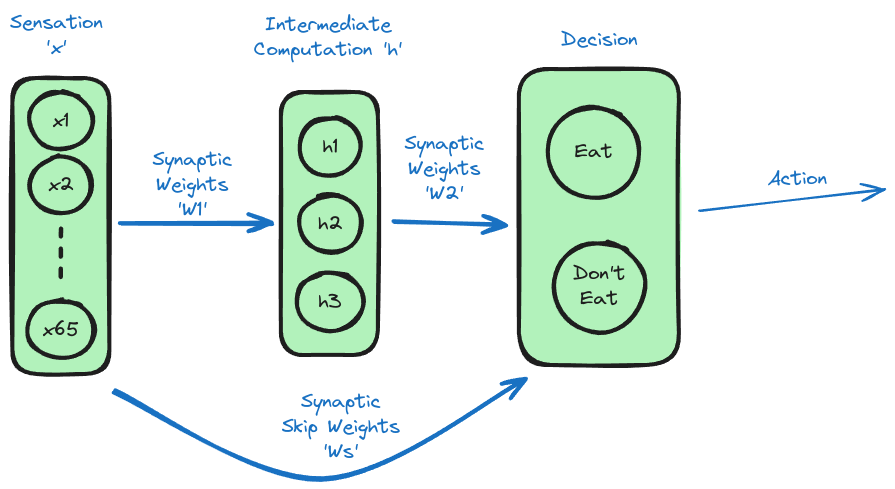

## Coding Exercise: Implement a Decision Function

That's the math of the decision problem. Now, how do we get a computer to actually implement that decision function? Do the coding exercise below to find out.

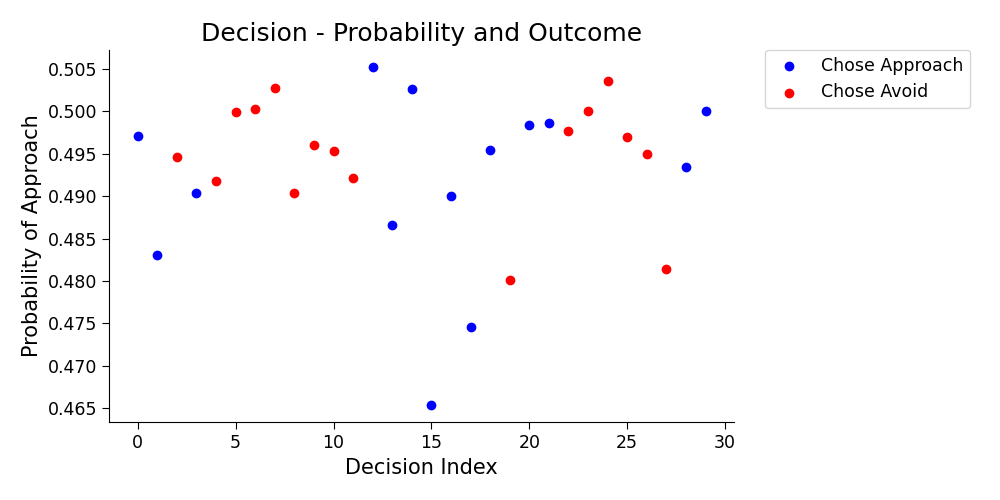

In [4]:
# to_remove solution
import jax
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy as jscipy
from jax import grad, jit

def jnp_sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

def jnp_softmax(x):
  # x is n x batch
  e_x = jnp.exp(x - jscipy.special.logsumexp(x, axis=0, keepdims=True))
  return e_x

@jit
def calc_decision_probs_s(x, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  probs = jnp_softmax(z)
  return probs

@jit
def calc_decision_probs_ns(x, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  probs = jnp_softmax(z)
  return probs

@jit
def make_decision_s(x, W1, Ws, W2, rnd_key):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  sample = jrandom.categorical(rnd_key, logits=z, axis=0) # batch
  return sample

@jit
def make_decision_ns(x, W1, W2, rnd_key):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  sample = jrandom.categorical(rnd_key, logits=z, axis=0) # batch
  return sample

# plotting outcome of randomly initialized net
# Define the dimensions
n_in = 785  # 784 features + 1 bias
n_hid = 3
n_out = 2
# Initialize weights
key = jrandom.key(0)
key, rs1, rs2, rs3 = jrandom.split(key, num=4)
W1_test = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
Ws_test = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
W2_test = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output
# Grab test data
x_batch = jnp.array(X_bin_aug1[:30].T)
# make decision
probabilities = calc_decision_probs_s(x_batch, W1_test, Ws_test, W2_test)
samples = make_decision_s(x_batch, W1_test, Ws_test, W2_test, key)
# Plot results
fig, ax = plt.subplots(figsize=(10, 5))
eating_indices = [i for i, s in enumerate(samples) if s == 0]
not_eating_indices = [i for i, s in enumerate(samples) if s == 1]
eating_probabilities = [probabilities[0,i] for i in eating_indices]
not_eating_probabilities = [probabilities[0,i] for i in not_eating_indices]
ax.scatter(eating_indices, eating_probabilities, color='blue', label='Chose Approach')
ax.scatter(not_eating_indices, not_eating_probabilities, color='red', label='Chose Avoid')
ax.set_title('Decision - Probability and Outcome')
ax.set_xlabel('Decision Index')
ax.set_ylabel('Probability of Approach')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()



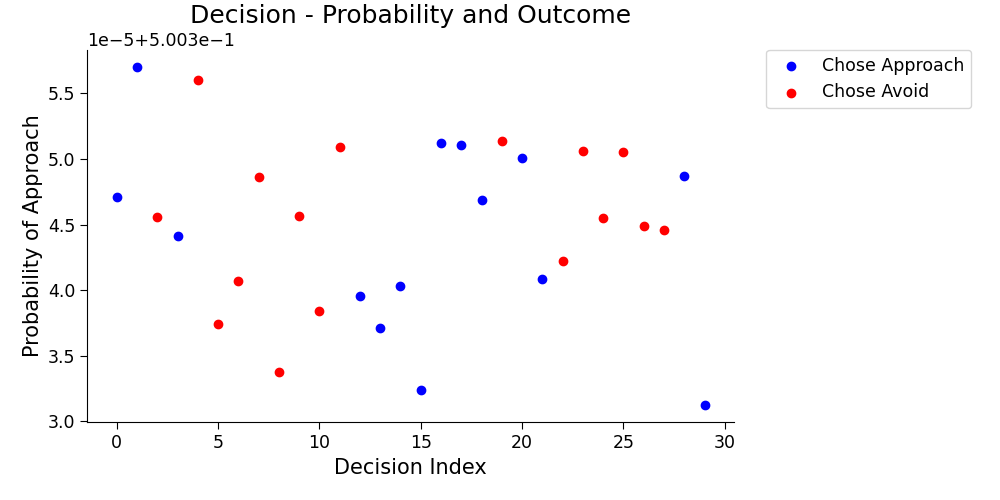

In [5]:
probabilities = calc_decision_probs_ns(x_batch, W1_test, W2_test)
samples = make_decision_ns(x_batch, W1_test, W2_test, key)
# Plot results
fig, ax = plt.subplots(figsize=(10, 5))
eating_indices = [i for i, s in enumerate(samples) if s == 0]
not_eating_indices = [i for i, s in enumerate(samples) if s == 1]
eating_probabilities = [probabilities[0,i] for i in eating_indices]
not_eating_probabilities = [probabilities[0,i] for i in not_eating_indices]
ax.scatter(eating_indices, eating_probabilities, color='blue', label='Chose Approach')
ax.scatter(not_eating_indices, not_eating_probabilities, color='red', label='Chose Avoid')
ax.set_title('Decision - Probability and Outcome')
ax.set_xlabel('Decision Index')
ax.set_ylabel('Probability of Approach')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

The important thing to note here is the fundamental stochasticity in the decision function. This particular initialization seems to be slight biased towards `approach`, but even so `avoid` actions are still taken with some frequency. Different parameterizations of the behavioural policy can have more or less variability in action selection given a particular sensory experience.

# 0.1.1.2 Evolving a Good Behavioural Policy with Selection on Noisy Heritable Variation:

Now we get to see the power of selection in action. A very simple process, generates variation and then selects from amongst that variation for those variants that perform better according to some criterion (in this case eat more nutritious things in a life). This process is applied iteratively over many generations, using the selected variants as the starting point for the next generation's variation. By iterating this simple process we can arrive at an effective solution to this eat-don't-eat binary discrimination problem. Let's code it up and see it in action.

## Coding Exercsise: Implement Behaviour Policy Evaluation

We have our decision function already, but now we need a way of evaluating this decision function, i.e. giving it a score upon which will determine how many offspring an organism will contribute to the next generation. This score should be how many times an organism approaches nutritious food in it's life. Complete the coding exercise below to calculate the score for an organism with a given decision function, assuming a given sequence of episodes.

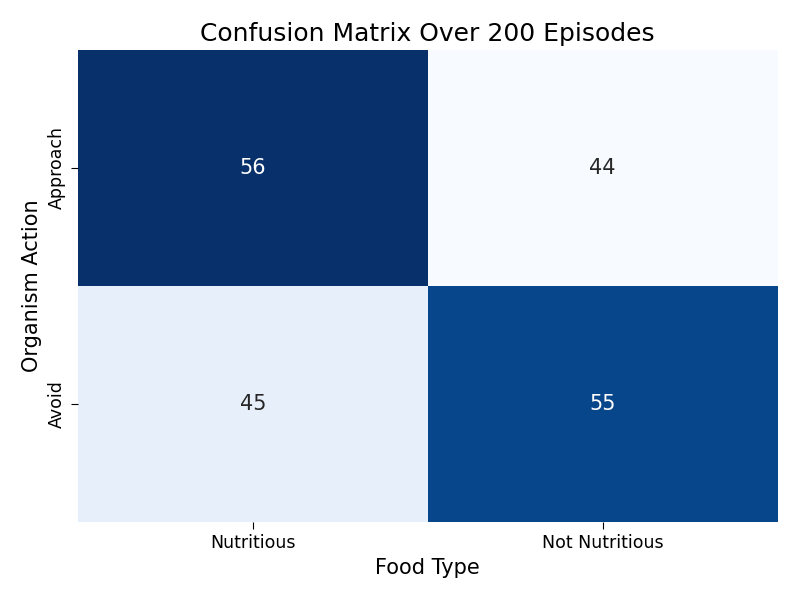

In [6]:
# to_remove solution

@jit
def eval_policy_s(W1, Ws, W2, #jnp arrays params of decision function
                  rnd_key, #jrandom.key
                  X, #array batch x n_in
                  y, #array batch
                  nutritious_type, # integer label
                  lifetime): #postive integer
  x_batch = X.T # n_in x batch
  samples = make_decision_s(x_batch, W1, Ws, W2, rnd_key) # batch, n_out x batch
  did_approach = samples == 0
  did_avoid = samples == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  batch_time = jnp.where(did_avoid, 1, 2)  # 1 time unit for avoid, 2 for approach
  batch_TP = jnp.where(was_nutritious & did_approach, 1, 0)
  batch_FP = jnp.where(was_waste & did_approach, 1, 0)
  batch_FN = jnp.where(was_nutritious & did_avoid, 1, 0)
  batch_TN = jnp.where(was_waste & did_avoid, 1, 0)
  # only count what happens before they run out of time
  cum_time = jnp.cumsum(batch_time)
  indices = cum_time <= lifetime
  batch_TP = jnp.where(indices, batch_TP, 0)
  batch_FP = jnp.where(indices, batch_FP, 0)
  batch_FN = jnp.where(indices, batch_FN, 0)
  batch_TN = jnp.where(indices, batch_TN, 0)
  TP = jnp.sum(batch_TP)
  FP = jnp.sum(batch_FP)
  FN = jnp.sum(batch_FN)
  TN = jnp.sum(batch_TN)
  return TP, FN, FP, TN


@jit
def eval_policy_ns(W1, W2, #jnp arrays params of decision function
                   rnd_key, #jrandom.key
                   X, #array batch x n_in
                   y, #array batch
                   nutritious_type, # integer label
                   lifetime): #postive integer
  x_batch = X.T # n_in x batch
  samples = make_decision_ns(x_batch, W1, W2, rnd_key) # batch, n_out x batch
  did_approach = samples == 0
  did_avoid = samples == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  batch_time = jnp.where(did_avoid, 1, 2)  # 1 time unit for avoid, 2 for approach
  batch_TP = jnp.where(was_nutritious & did_approach, 1, 0)
  batch_FP = jnp.where(was_waste & did_approach, 1, 0)
  batch_FN = jnp.where(was_nutritious & did_avoid, 1, 0)
  batch_TN = jnp.where(was_waste & did_avoid, 1, 0)
  # only count what happens before they run out of time
  cum_time = jnp.cumsum(batch_time)
  indices = cum_time <= lifetime
  batch_TP = jnp.where(indices, batch_TP, 0)
  batch_FP = jnp.where(indices, batch_FP, 0)
  batch_FN = jnp.where(indices, batch_FN, 0)
  batch_TN = jnp.where(indices, batch_TN, 0)
  TP = jnp.sum(batch_TP)
  FP = jnp.sum(batch_FP)
  FN = jnp.sum(batch_FN)
  TN = jnp.sum(batch_TN)
  return TP, FN, FP, TN


# plotting outcome of randomly initialized net
# Define the dimensions
# Initialize weights and test data
n_in = 785
n_hid = 3
n_out = 2
lifetime = 300
test_size = lifetime
nutritious_type = 1
rnd_key = jrandom.key(0)
rnd_key, shuffle_key = jrandom.split(rnd_key)
shuffled_indices = jrandom.permutation(shuffle_key, X_bin_aug1.shape[0])
selected_indices = shuffled_indices[:lifetime]
X_test = jnp.array(X_bin_aug1[selected_indices, :])
y_test = jnp.array(y_bin_aug[selected_indices])
W1_test = jnp.zeros((n_hid, n_in)) # Weights from input to hidden layer
Ws_test = jnp.zeros((n_out, n_in)) # Weights from input to output
W2_test = jnp.zeros((n_out, n_hid)) # Weights from hidden to output
# Evaluate
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN = eval_policy_s(
  W1_test, Ws_test, W2_test, eval_key, X_test, y_test,
  nutritious_type=1, lifetime=300)
total_trials = TP + FN + FP + TN
confusion_matrix = np.array([[TP, FP], [FN, TN]])

fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
# Labels, title and ticks
column_labels = ['Nutritious', 'Not Nutritious']
row_labels = ['Approach', 'Avoid']
ax.set_xlabel('Food Type')
ax.set_ylabel('Organism Action')
ax.set_title(f'Confusion Matrix Over {total_trials} Episodes')
ax.xaxis.set_ticklabels(column_labels)
ax.yaxis.set_ticklabels(row_labels)
remove_ip_clutter(fig)
plt.show()

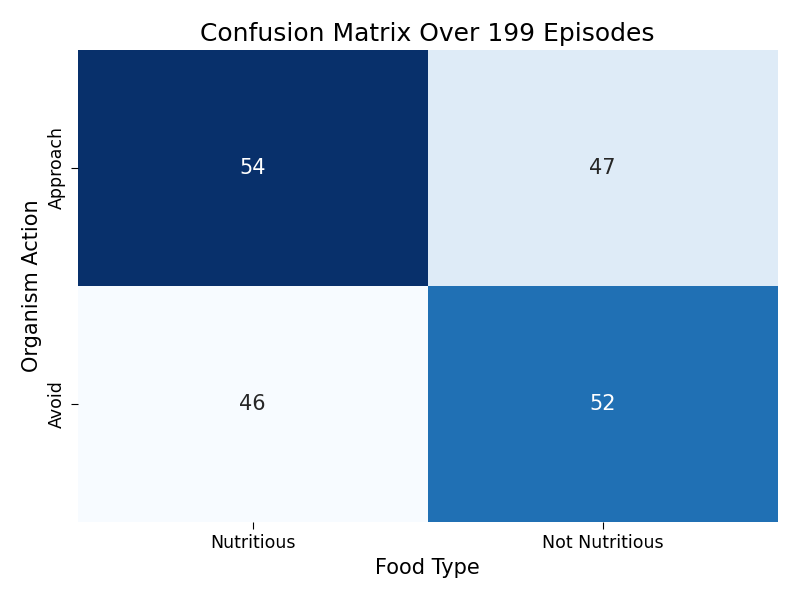

In [7]:
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN = eval_policy_ns(
  W1_test, W2_test, eval_key, X_test, y_test,
  nutritious_type=1, lifetime=300)
total_trials = TP + FN + FP + TN
confusion_matrix = np.array([[TP, FP], [FN, TN]])

fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
# Labels, title and ticks
column_labels = ['Nutritious', 'Not Nutritious']
row_labels = ['Approach', 'Avoid']
ax.set_xlabel('Food Type')
ax.set_ylabel('Organism Action')
ax.set_title(f'Confusion Matrix Over {total_trials} Episodes')
ax.xaxis.set_ticklabels(column_labels)
ax.yaxis.set_ticklabels(row_labels)
remove_ip_clutter(fig)
plt.show()

Looking at the confusion matrix (what the organism did in different cases, contrasted with what it should have done) we see that over 208 trials it approached and ate nutritious food 46 times, so this would be the score that determines how likely this organism is to be a parent in the next generation. It spent its 300 unit lifetime on those 208 trials as follows:
In 116 of them it avoided food, and this used 116 time units of life. Of these 116 times it chose avoid, in 52 of them it made the 'wrong' choice and missed out on nutritious food, but in 64 of them in made the 'right' choice and avoided wasting time on non-nutritious food. In 92 cases it approached food, taking up 184 time units of life. Of these 92 approach cases, 46 times it approached nutritious food, but 46 times it approached non-nutritrious food that it would have been better off avoiding. In this test case the organism is initilized with zeroed out parameter weights so it is equally likely to approach or avoid independent of what it senses. If instead, the organism had parameters that allowed it to perfectly discriminate between nutritiours and non-nutritious food it would have been able to get a score of at least 92 instead of 46, possibly more depending on the order of experiences.

## Coding Exercise: Implement Agent Based Evolution Simulation

Now that we have an evaluation function for these organisms, something that measures how well fit to their (very simple) ecological niche we are in a possition to implement a simulation of their life history and the evolutionary process.

Gen: 1/400 | Avg Score: 523.3400 | Std Score: 13.9744 | Reproductive Skew: 0.04 | Gen Time: 12.61s | Total Time: 12.61s
Gen: 2/400 | Avg Score: 530.4700 | Std Score: 17.1735 | Reproductive Skew: 0.03 | Gen Time: 4.62s | Total Time: 17.23s
Gen: 3/400 | Avg Score: 532.1700 | Std Score: 13.8644 | Reproductive Skew: 0.08 | Gen Time: 3.42s | Total Time: 20.65s
Gen: 4/400 | Avg Score: 523.3900 | Std Score: 12.7451 | Reproductive Skew: 0.02 | Gen Time: 2.93s | Total Time: 23.58s
Gen: 5/400 | Avg Score: 528.1800 | Std Score: 13.4851 | Reproductive Skew: 0.05 | Gen Time: 2.68s | Total Time: 26.26s
Gen: 6/400 | Avg Score: 553.2400 | Std Score: 16.3964 | Reproductive Skew: 0.02 | Gen Time: 3.31s | Total Time: 29.57s
Gen: 7/400 | Avg Score: 552.0800 | Std Score: 13.8814 | Reproductive Skew: 0.05 | Gen Time: 2.73s | Total Time: 32.31s
Gen: 8/400 | Avg Score: 544.1400 | Std Score: 15.8348 | Reproductive Skew: 0.02 | Gen Time: 1.70s | Total Time: 34.01s
Gen: 9/400 | Avg Score: 560.2800 | Std Score: 1

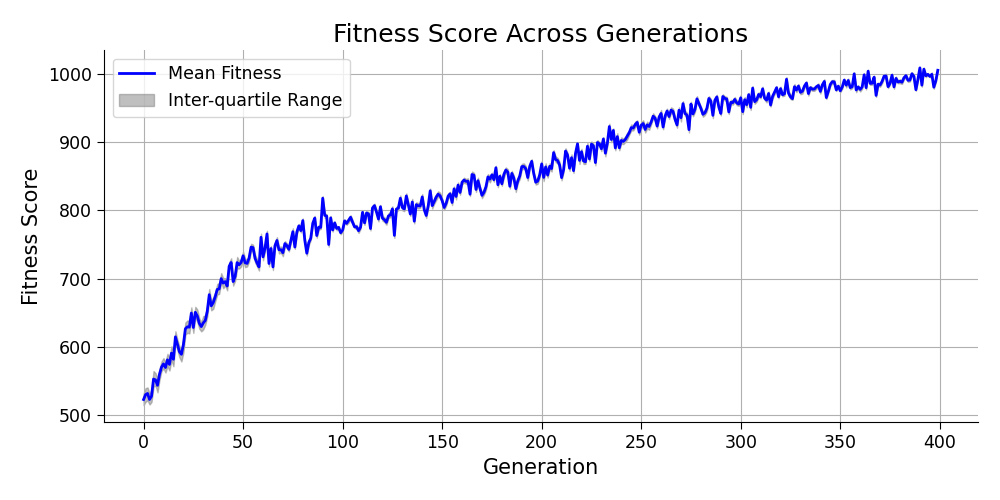

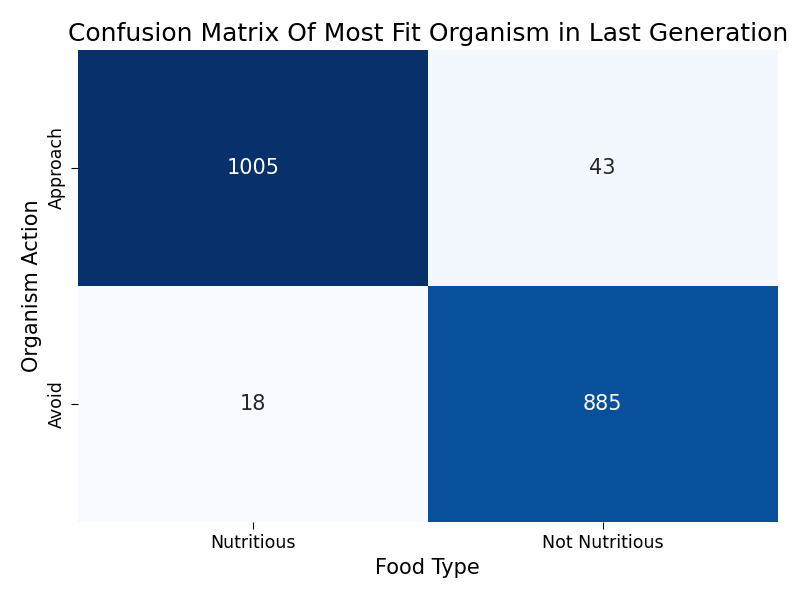

In [8]:
def init_critter(n_in, n_hid, n_out, rnd_key):
  rs1, rs2, rs3 = jrandom.split(rnd_key, num=3)
  W1 = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
  Ws = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
  W2 = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output
  critter_params = DotDict({
    'W1': W1, 'W2': W2, 'Ws': Ws
  })
  return critter_params

def select_parents(fitness_scores, rnd_key, sel_str):
  # note that probability of being a parent is directly proportional to
  # 'fitness' score resulting from the evaluaton function
  probabilities = jnp_softmax(fitness_scores/sel_str)
  probabilities = probabilities / probabilities.sum()  # Normalize to ensure sum is exactly 1
  cumulative_probabilities = jnp.cumsum(probabilities)
  selection_points = jrandom.uniform(rnd_key, (len(fitness_scores),))
  parent_indices = jnp.searchsorted(cumulative_probabilities, selection_points)
  return parent_indices

def calc_pop_fitness_ns(population, X_gen, y_gen, nutritious_type, lifetime, rnd_key):
  fitness_scores = jnp.zeros(len(population))
  for i, critter in enumerate(population):
    rnd_key, eval_key = jrandom.split(rnd_key)
    fitness_scores = fitness_scores.at[i].set(
      eval_policy_ns(
        critter['W1'], critter['W2'],
        eval_key, X_gen, y_gen,
        nutritious_type, lifetime
      )[0]  # Assuming this returns a scalar fitness value
    )
  return fitness_scores

def calc_pop_fitness_s(population, X_gen, y_gen, nutritious_type, lifetime, rnd_key):
  fitness_scores = jnp.zeros(len(population))
  for i, critter in enumerate(population):
    rnd_key, eval_key = jrandom.split(rnd_key)
    fitness_scores = fitness_scores.at[i].set(
      eval_policy_s(
        critter['W1'], critter['Ws'], critter['W2'],
        eval_key, X_gen, y_gen,
        nutritious_type, lifetime
      )[0]  # Assuming this returns a scalar fitness value
    )
  return fitness_scores

def mutate(parent_params, rnd_key, mutation_scale):
  mutated_params = DotDict({})
  for key, weights in parent_params.items():
    rnd_key, mut_key = jrandom.split(rnd_key)
    noise = jrandom.normal(mut_key, weights.shape) * mutation_scale
    mutated_params[key] = weights + noise
  return mutated_params

#simulation params
num_generations = 400
lifetime = 3000
pop_size = 100
nutritious_type = 1
mutation_scale = 0.02
softmax_selection_strength_temp = 2.0 # close to zero is strong selection, large positive is weak selection
n_in = 785
n_out = 2
n_hid = 3

rnd_key = jrandom.key(0)
population = []

for _ in range(pop_size):
  rnd_key, split_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, split_key))

indices_0 = jnp.where(y_bin_aug == 0)[0]
indices_1 = jnp.where(y_bin_aug == 1)[0]
fitness_history = []
best_params = DotDict({})
start_time = time.time()
for g in range(num_generations):
  gen_start_time = time.time()
  #everyone in same gen has same experiences
  # move this indices shuffle inside calculate fitness scores to change that
  rnd_key, shuffle_key0 = jrandom.split(rnd_key)
  shuffled_indices_0 = jrandom.permutation(shuffle_key0, indices_0.shape[0])
  rnd_key, shuffle_key1 = jrandom.split(rnd_key)
  shuffled_indices_1 = jrandom.permutation(shuffle_key1, indices_1.shape[0])
  # balanced food non-food in environment
  num_samples_per_class = lifetime // 2
  selected_indices_0 = indices_0[shuffled_indices_0[:num_samples_per_class]]
  selected_indices_1 = indices_1[shuffled_indices_1[:num_samples_per_class]]
  selected_indices = jnp.concatenate([selected_indices_0, selected_indices_1])
  rnd_key, shuffle_key_final = jrandom.split(rnd_key)
  selected_indices = jrandom.permutation(shuffle_key_final, selected_indices.shape[0])
  X_gen = jnp.array(X_bin_aug1[selected_indices, :])
  y_gen = jnp.array(y_bin_aug[selected_indices])
  # calc fitness scores
  rnd_key, fit_key = jrandom.split(rnd_key)
  fitness_scores = calc_pop_fitness_ns(population, X_gen, y_gen,
                                       nutritious_type, lifetime, fit_key)
  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key, softmax_selection_strength_temp)
  unique_parents_count = len(jnp.unique(parent_indices))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = population[best_idx]  # Retrieve the best individual's parameters
  new_population = []
  for idx in parent_indices:
    rnd_key, mutation_key = jrandom.split(rnd_key)
    new_population.append(mutate(population[idx], mutation_key, mutation_scale))
  population = new_population
  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q25_fitness': jnp.percentile(fitness_scores, 25).item(),
    'q75_fitness': jnp.percentile(fitness_scores, 75).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  print(f"Gen: {g+1}/{num_generations} | Avg Score: {current_gen_data['mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q25_fitness = [data['q25_fitness'] for data in fitness_history]
q75_fitness = [data['q75_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness', color='blue', linewidth=2)
ax.fill_between(generations, q25_fitness, q75_fitness, color='gray', alpha=0.5, label='Inter-quartile Range')
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN = eval_policy_ns(
  best_params.W1, best_params.W2, eval_key, X_gen, y_gen,
  nutritious_type=1, lifetime=lifetime)
total_trials = TP + FN + FP + TN
confusion_matrix = np.array([[TP, FP], [FN, TN]])
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
# Labels, title and ticks
column_labels = ['Nutritious', 'Not Nutritious']
row_labels = ['Approach', 'Avoid']
ax.set_xlabel('Food Type')
ax.set_ylabel('Organism Action')
ax.set_title(f'Confusion Matrix Of Most Fit Organism in Last Generation')
ax.xaxis.set_ticklabels(column_labels)
ax.yaxis.set_ticklabels(row_labels)
remove_ip_clutter(fig)
plt.show()

Gen: 1/100 | Avg Score: 523.1400 | Std Score: 13.7833 | Reproductive Skew: 0.04 | Gen Time: 5.15s | Total Time: 5.15s
Gen: 2/100 | Avg Score: 534.7300 | Std Score: 26.7548 | Reproductive Skew: 0.03 | Gen Time: 6.12s | Total Time: 11.27s
Gen: 3/100 | Avg Score: 551.6500 | Std Score: 27.5247 | Reproductive Skew: 0.01 | Gen Time: 3.43s | Total Time: 14.71s
Gen: 4/100 | Avg Score: 594.9400 | Std Score: 19.3984 | Reproductive Skew: 0.03 | Gen Time: 4.28s | Total Time: 18.99s
Gen: 5/100 | Avg Score: 619.9700 | Std Score: 22.2385 | Reproductive Skew: 0.02 | Gen Time: 3.38s | Total Time: 22.37s
Gen: 6/100 | Avg Score: 682.8700 | Std Score: 18.6508 | Reproductive Skew: 0.05 | Gen Time: 4.49s | Total Time: 26.86s
Gen: 7/100 | Avg Score: 707.7100 | Std Score: 17.4541 | Reproductive Skew: 0.09 | Gen Time: 3.34s | Total Time: 30.20s
Gen: 8/100 | Avg Score: 696.3500 | Std Score: 17.5712 | Reproductive Skew: 0.07 | Gen Time: 4.24s | Total Time: 34.43s
Gen: 9/100 | Avg Score: 720.8700 | Std Score: 18.

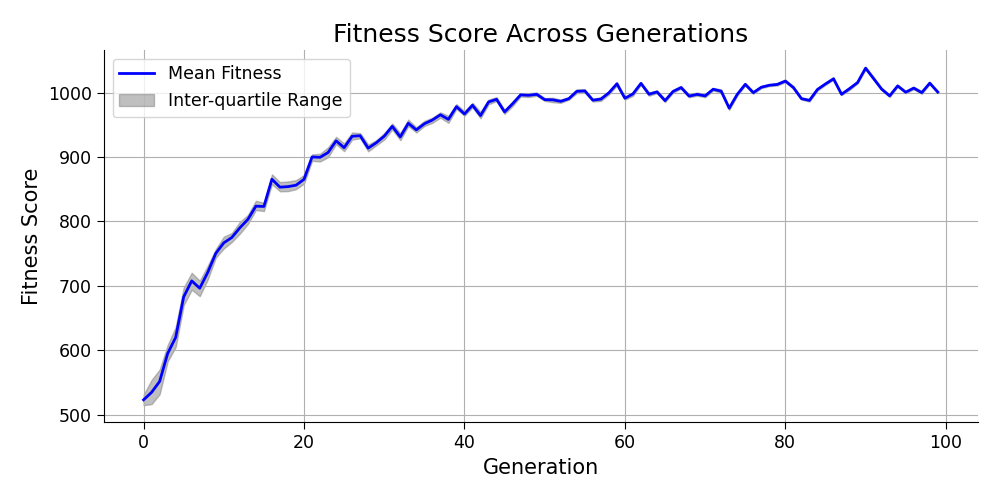

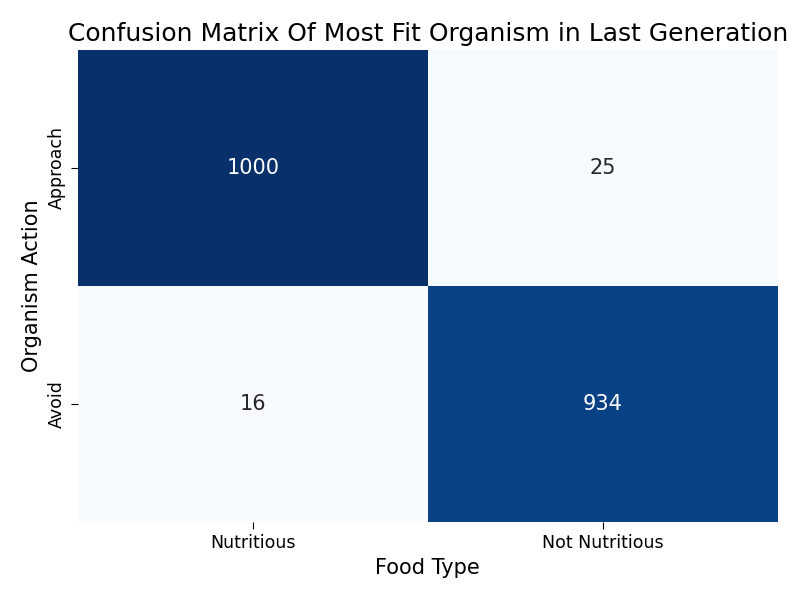

In [49]:
#simulation params
num_generations = 100
lifetime = 3000
pop_size = 100
nutritious_type = 1
mutation_scale = 0.02
softmax_selection_strength_temp = 2.0 # close to zero is strong selection, large positive is weak selection
n_in = 785
n_out = 2
n_hid = 3

rnd_key = jrandom.key(0)
population = []

for _ in range(pop_size):
  rnd_key, split_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, split_key))

indices_0 = jnp.where(y_bin_aug == 0)[0]
indices_1 = jnp.where(y_bin_aug == 1)[0]
fitness_history = []
best_params = DotDict({})
start_time = time.time()
for g in range(num_generations):
  gen_start_time = time.time()
  #everyone in same gen has same experiences
  # move this indices shuffle inside calculate fitness scores to change that
  rnd_key, shuffle_key0 = jrandom.split(rnd_key)
  shuffled_indices_0 = jrandom.permutation(shuffle_key0, indices_0.shape[0])
  rnd_key, shuffle_key1 = jrandom.split(rnd_key)
  shuffled_indices_1 = jrandom.permutation(shuffle_key1, indices_1.shape[0])
  # balanced food non-food in environment
  num_samples_per_class = lifetime // 2
  selected_indices_0 = indices_0[shuffled_indices_0[:num_samples_per_class]]
  selected_indices_1 = indices_1[shuffled_indices_1[:num_samples_per_class]]
  selected_indices = jnp.concatenate([selected_indices_0, selected_indices_1])
  rnd_key, shuffle_key_final = jrandom.split(rnd_key)
  selected_indices = jrandom.permutation(shuffle_key_final, selected_indices.shape[0])
  X_gen = jnp.array(X_bin_aug1[selected_indices, :])
  y_gen = jnp.array(y_bin_aug[selected_indices])
  # calc fitness scores
  rnd_key, fit_key = jrandom.split(rnd_key)
  fitness_scores = calc_pop_fitness_s(population, X_gen, y_gen,
                                      nutritious_type, lifetime, fit_key)
  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key, softmax_selection_strength_temp)
  unique_parents_count = len(jnp.unique(parent_indices))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = population[best_idx]  # Retrieve the best individual's parameters
  new_population = []
  for idx in parent_indices:
    rnd_key, mutation_key = jrandom.split(rnd_key)
    new_population.append(mutate(population[idx], mutation_key, mutation_scale))
  population = new_population
  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q25_fitness': jnp.percentile(fitness_scores, 25).item(),
    'q75_fitness': jnp.percentile(fitness_scores, 75).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  print(f"Gen: {g+1}/{num_generations} | Avg Score: {current_gen_data['mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q25_fitness = [data['q25_fitness'] for data in fitness_history]
q75_fitness = [data['q75_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness', color='blue', linewidth=2)
ax.fill_between(generations, q25_fitness, q75_fitness, color='gray', alpha=0.5, label='Inter-quartile Range')
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN = eval_policy_s(
  best_params.W1, best_params.Ws, best_params.W2, eval_key, X_gen, y_gen,
  nutritious_type=1, lifetime=lifetime)
total_trials = TP + FN + FP + TN
confusion_matrix = np.array([[TP, FP], [FN, TN]])
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
# Labels, title and ticks
column_labels = ['Nutritious', 'Not Nutritious']
row_labels = ['Approach', 'Avoid']
ax.set_xlabel('Food Type')
ax.set_ylabel('Organism Action')
ax.set_title(f'Confusion Matrix Of Most Fit Organism in Last Generation')
ax.xaxis.set_ticklabels(column_labels)
ax.yaxis.set_ticklabels(row_labels)
remove_ip_clutter(fig)
plt.show()

Thematize Slowness, it takes about 50 generation to go from flailer to pretty much dialed in with skip connections, and more like 400 with-out. Simple static figure contrasts evolution with learning and evolution without learning, interactive figure is a slide show, where each picture is 10 things the best critter in a generation did eat (wrong or right indicated with border) 10 things it didn't eat (wrong or right indicated with a border), and then it's full confusion matrix for reference, same color coding as the borders, do every 10 generations, with a ... many (~X) generations pass slide in there. Another possibility to to have different curves for different mutations rates, populations sizes and lifetime lengths... how do these interact, a little grid search likely required to justify this, maybe just mutation rate, take pop size and lifetime length as given.

While initial improvement is rapid, to really dial in the discrimination using an evolutionary process like this will take a very long time. The issue is that to achieve near perfect discriminiation on this task requires the precise coadaption of many parameters of the behavioural policy, and given that this evolutionary processes explores possible parameter configurations using random perturbations, the chances of hitting upon the exact right set of parameter changes that will lead to improvement is a low probability event. Many generations might pass

# 0.1.1.3 Evolving to Learn a Good Behavioural Policy

In the previous section, evolution had to basically use trial and error to hit upon good parameter combinations that resulted in a good behavioural policy in terms of eating lots of nutritious food and avoiding wasting time on non-nutritious food. Organism's with good policies in this sense were more likely to have offspring in the next generations (selection) and these offspring resembled their parents with minor modification ('mutation' in the form gaussian noise added to the parents' parameters), and so over many generations this process settled in on relatively good parameters, i.e. ones that achieved near perfect discrimination. But this was slow, ~50 generations for one of the network archetectures, ~400 for another less efficient network archetecture. Another possibility is that instead of evolution selecting the parameters of the behavioural function directly, it could instead have selected for a learning process that rapidly aquires adaptive behaviour.

For simplicity we will not, at this time, set up a fully general/evolvable set of network plasticity rules, instead we will take as given the evolution has somehow discovered and implemented the following behavioural update rule:

After experiencing a given sensory stimulous $\mathbf{x}$ the organism responsed be taking an action $a$ which is either 'Approach' or 'Avoid'. Now in the case of 'Avoid' the episode is over and the organism simply begins to search for another potential food item, but in the case of 'Approach' the organism then goes on to have an additional sensory experience $s$, and this $s$ will be simple binary variable indicating which class, $0$ or $1$, the approached food belonged too. We then suppose that evolution has specified an association of immediate reward in the form of a function $r(s)$ and that this experience of reward drives behavioural policy parameter updates in the following way:

$$\Delta \theta = \eta \cdot r \cdot \nabla_\theta \log(\pi_{\theta}(a | \mathbf{x}))$$

Here we are denoting the parameters of the behavioural policy ($\mathbf{W}^1$, $\mathbf{W}^2$, $\mathbf{W}^s$) in aggregate as the vector $\theta$, the probability that the selected action $a$ was taken given the initial sensory experience of $\mathbf{x}$ and the current parameter values, $\theta$, of the behavioural policy is $\pi_{\theta}(a | \mathbf{x})$, $r$ is the reward experienced following the 'Approach' action, if the 'Avoid' action is taken effectively an $r$ value of 0 is obtained and the behavioural policy is not updated.

What this is essentially saying is that a simple form of associative learning is at play whereby actions that are taken are reinforced proportionally to the rewards that result from taking those actions. This is achieved by shifting the parameters $\theta$ in such a way that the log probability (and hence the probability) of the action taken is increased if a positive reward is obtained, in proportion to the strength of that reward, and conversely that the log probability (and hence the probability) of the action taken is decreased if a negative reward is obtained, again in proportion to the strength of that reward. This is because $\nabla_\theta \log(\pi_{\theta}(a | \mathbf{x}))$ is the *gradient* of the behavioural policy's (log) probability of selecting action $a$ given stimulous $\mathbf{x}$. (How evolution might discover and implement such a gradient following update rule is an important and complex question that we leave aside for the moment.)


_______________________
## Aside: - Why the Gradient of Log Probabilities
You may be wondering why we are using the log probability and the raw probability here. There are two very good reasons why we use the gradient of the log probability and not the gradient of the probability in this update rule. Briefly, using log probability is 1) consistent with maximizing expected reward, and 2) computationally much easier to work with. In this simple problem a learning rule that used the raw probabilities will be basically as effective as one using the raw probabilities, but in more complicated situations using the gradient of the log probabilities becomes a necessity for efficient learning.
______


We want to embedd this learning process within an evolutionary process. To do this we will allow both the initial parameters of the behavioural policy function to be targets of evolution (i.e. the parameters are inherited with sligh variation), and we will parameterize the learning process by allowing the reward value $r$ for the two different types of food to also be inherited. Let's reimplement our evolutionary simulation, but now with within-lifetime learning

## Coding Exercise: Implement a Decision and Reward Function

In [ ]:
# to_remove solution
@jit
def reward_s(W1, Ws, W2, #jnp arrays params of decision function
             rnd_key, #jrandom.key
             X, #array n_in x batch
             y, #array batch
             r_approach_0,
             r_approach_1,
             r_avoid_0 = 0,
             r_avoid_1 = 0):
  actions = make_decision_s(X, W1, Ws, W2, rnd_key) # batch, n_out x batch
  did_approach = actions == 0
  did_avoid = actions == 1
  was_0 = y == 0 # batch
  was_1 = y ==1
  approach_0 = was_0 & did_approach
  approach_1 = was_1 & did_approach
  avoid_0 = was_0 & did_avoid
  avoid_1 = was_1 & did_avoid
  rewards = (r_approach_0 * approach_0 +
             r_approach_1 * approach_1 +
             r_avoid_0 * avoid_0 +
             r_avoid_1 * avoid_1)
  return actions, rewards

@jit
def reward_ns(W1, W2, #jnp arrays params of decision function
             rnd_key, #jrandom.key
             X, #array n_in x batch
             y, #array batch
             r_approach_0,
             r_approach_1,
             r_avoid_0 = 0,
             r_avoid_1 = 0):
  actions = make_decision_ns(X, W1, W2, rnd_key) # batch, n_out x batch
  did_approach = actions == 0
  did_avoid = actions == 1
  was_0 = y == 0 # batch
  was_1 = y ==1
  approach_0 = was_0 & did_approach
  approach_1 = was_1 & did_approach
  avoid_0 = was_0 & did_avoid
  avoid_1 = was_1 & did_avoid
  rewards = (r_approach_0 * approach_0 +
             r_approach_1 * approach_1 +
             r_avoid_0 * avoid_0 +
             r_avoid_1 * avoid_1)
  return actions, rewards

Recal that the behavioural policy is defined as:

$$ \mathbf{h} = \sigma(\mathbf{W}^1\mathbf{x}) $$
$$\mathbf{z} = \mathbf{W}^{\text{s}}\mathbf{x} + \mathbf{W}^2 \mathbf{h}$$

$$\pi(\text{Approach} |\mathbf{x}) = \text{softmax}_0(\mathbf{z})$$
and
$$\pi(\text{Avoid} |\mathbf{x}) = \text{softmax}_1(\mathbf{z})$$

Usinf this and the update rule above we are going to implement the behavioural update rule within our evolutionary simulation. To do this we will need to extend our `make_decision` function, to also return the reward experienced by the organism

# 0.1.1.3 Learning a Good Behavioural Policy with Policy Gradients

To first demonstrate the a better policy is even possible we are going to try to 'learn' a policy based on a very simple idea. When the organism takes an action and recieves a reward, it will update the parameters of the policy in such a way that the probability of taking the action that resulted in the reward becomes more likely for the initial sensory stimulus that triggered the behaviour in the first place. This kind of simple associative 'reinforcement learning' is broadly observed across the animal kingdom, in many insects and mollusks, and all vertebrates.

Recall that our decision function

$$ \mathbf{h} = \sigma(\mathbf{W}^1\mathbf{x}) $$
$$\mathbf{z} = \mathbf{W}^{\text{s}}\mathbf{x} + \mathbf{W}^2 \mathbf{h}$$

$$\pi(\text{Approach} |\mathbf{x}) = \text{softmax}_0(\mathbf{z})$$
and
$$\pi(\text{Avoid} |\mathbf{x}) = \text{softmax}_1(\mathbf{z})$$


So now we leave aside for a moment populations and evolution and just focus on a single learning organism that will live forever, and we want it to improve it's behavioural policy based on experience as described above what will this look like. Let's start by adapting our `eval_policy` function to work on just a single experience, instead of a whole lifetime of experiences. Evaluating a whole lifetime was what was needed at the evolutionary time scale, but evaluation of a single experience is what is need on the time scale of an individual learning.

In [43]:
from jax import grad
@jit
def reward_s(W1, Ws, W2, #jnp arrays params of decision function
             rnd_key, #jrandom.key
             X, #array n_in x batch
             y, #array batch
             nutritious_type, # integer label
             r_TP = 3,
             r_FP = -1,
             r_TN = 0,
             r_FN = 0):
  samples = make_decision_s(X, W1, Ws, W2, rnd_key) # batch, n_out x batch
  did_approach = samples == 0
  did_avoid = samples == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  TP = was_nutritious & did_approach
  FP = was_waste & did_approach
  FN = was_nutritious & did_avoid
  TN = was_waste & did_avoid
  reward = r_TP * TP + r_FP * FP + r_TN * TN + r_FN * FN
  return reward, samples

@jit
def reward_ns(W1, W2, #jnp arrays params of decision function
              rnd_key, #jrandom.key
              X, #array n_in x batch
              y, #array batch
              nutritious_type, # integer label
              r_TP = 3,
              r_FP = -1,
              r_TN = 0,
              r_FN = 0):
  samples = make_decision_ns(X, W1, W2, rnd_key) # batch, n_out x batch
  did_approach = samples == 0
  did_avoid = samples == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  TP = was_nutritious & did_approach
  FP = was_waste & did_approach
  FN = was_nutritious & did_avoid
  TN = was_waste & did_avoid
  reward = r_TP * TP + r_FP * FP + r_TN * TN + r_FN * FN
  return reward, samples

def jnp_sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

def jnp_softmax(x):
  # x is n x batch
  e_x = jnp.exp(x - jscipy.special.logsumexp(x, axis=0, keepdims=True))
  return e_x

@jit
def calc_decision_probs_s(x, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  probs = jnp_softmax(z)
  return probs

@jit
def calc_decision_probs_ns(x, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  probs = jnp_softmax(z)
  return probs

@jit
def calc_log_decision_probs_by_action_s(x, a, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  all_log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_probs = all_log_probs[jnp.arange(a.shape[0]), a]
  return chosen_log_probs

@jit
def calc_log_decision_probs_by_action_ns(x, a, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  all_log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_probs = all_log_probs[jnp.arange(a.shape[0]), a]
  return chosen_log_probs

@jit
def make_decision_s(x, W1, Ws, W2, rnd_key):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  sample = jrandom.categorical(rnd_key, logits=z, axis=0) # batch
  return sample

@jit
def make_decision_ns(x, W1, W2, rnd_key):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  sample = jrandom.categorical(rnd_key, logits=z, axis=0) # batch
  return sample

@jit
def reward_scaled_log_decision_probs_by_action_s(x, a, r, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  all_log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_probs = all_log_probs[jnp.arange(a.shape[0]), a] # batch
  r_scaled_log_probs = r * chosen_log_probs # batch
  mean_r_scaled_log_prob = jnp.mean(r_scaled_log_probs) #scalar
  return mean_r_scaled_log_prob

@jit
def reward_scaled_log_decision_probs_by_action_ns(x, a, r, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  all_log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_probs = all_log_probs[jnp.arange(a.shape[0]), a] # batch
  r_scaled_log_probs = r * chosen_log_probs # batch
  mean_r_scaled_log_prob = jnp.mean(r_scaled_log_probs) #scalar
  return mean_r_scaled_log_prob

rs_ldp_s_grad = grad(reward_scaled_log_decision_probs_by_action_s, argnums=[3,4,5])
# test out grad evaluation
nutritious_type = 1
n_in = 785  # 784 features + 1 bias
n_hid = 3
n_out = 2
# Initialize weights
key = jrandom.key(0)
key, rs1, rs2, rs3 = jrandom.split(key, num=4)
W1_test = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
Ws_test = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
W2_test = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output
# Grab test data
x_batch = jnp.array(X_bin_aug1[:30])
y_batch = jnp.array(y_bin_aug[:30])
# make decision
probabilities = calc_decision_probs_s(x_batch.T, W1_test, Ws_test, W2_test)
print(probabilities)
print(jnp.log(probabilities))
rewards, actions = reward_s(W1_test, Ws_test, W2_test, #jnp arrays params of decision function
                            key, #jrandom.key
                            x_batch.T, #array batch x n_in
                            y_batch, #array batch
                            nutritious_type, # integer label
                            r_TP = 3,
                            r_FP = -1,
                            r_TN = 0,
                            r_FN = 0)
print(jnp.log(probabilities[jnp.arange(actions.shape[0]), actions]))
calc_log_decision_probs_by_action_s(x_batch.T, actions, W1_test, Ws_test, W2_test)
W1_grad_test, Ws_grad_test, W2_grad_test = rs_ldp_s_grad(x_batch.T,
                                                         actions, rewards,
                                                         W1_test, Ws_test, W2_test)

[[0.49711448 0.48303786 0.49456748 0.49034524 0.49183226 0.49995074
  0.5002407  0.502758   0.4904236  0.49608153 0.4953832  0.49209934
  0.50526446 0.48666418 0.5026881  0.4653623  0.4900673  0.47460186
  0.49543    0.48010904 0.49836102 0.4986615  0.4976968  0.5000108
  0.5035769  0.49694625 0.49495468 0.48136768 0.4934827  0.5000135 ]
 [0.50288546 0.5169622  0.5054325  0.50965476 0.50816774 0.5000493
  0.49975935 0.49724194 0.5095764  0.50391847 0.50461686 0.50790066
  0.49473554 0.5133359  0.4973119  0.53463763 0.50993276 0.52539814
  0.50456995 0.519891   0.501639   0.5013385  0.5023032  0.49998918
  0.49642313 0.5030538  0.50504535 0.5186324  0.5065173  0.4999865 ]]
[[-0.6989349  -0.72766024 -0.70407164 -0.7126456  -0.70961756 -0.6932457
  -0.69266593 -0.68764627 -0.7124858  -0.701015   -0.7024237  -0.7090747
  -0.6826733  -0.720181   -0.6877854  -0.764939   -0.71321255 -0.745279
  -0.7023292  -0.73374206 -0.6964305  -0.6958278  -0.6977643  -0.6931256
  -0.6860189  -0.6992734  -0

Epoch 0, Iteration 0: Cum Avg Reward = [3.]


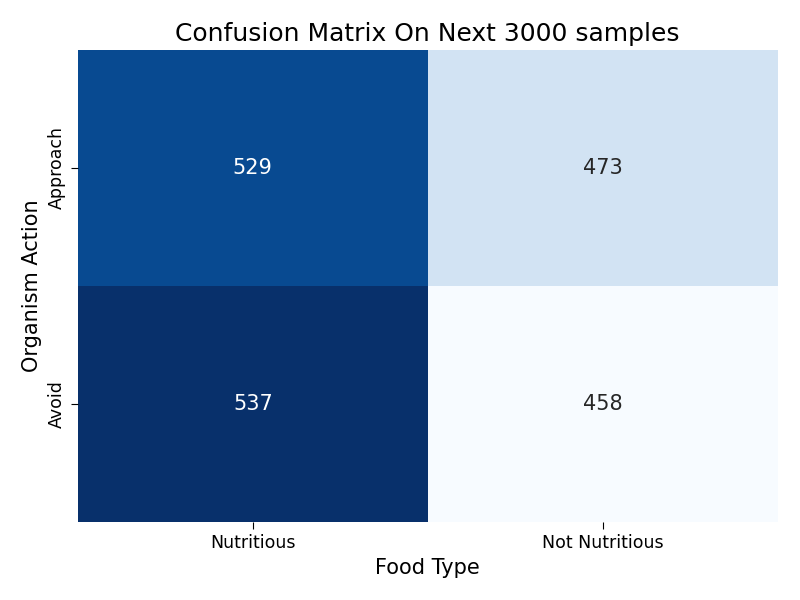

Epoch 0, Iteration 3000: Cum Avg Reward = [1.5594802]


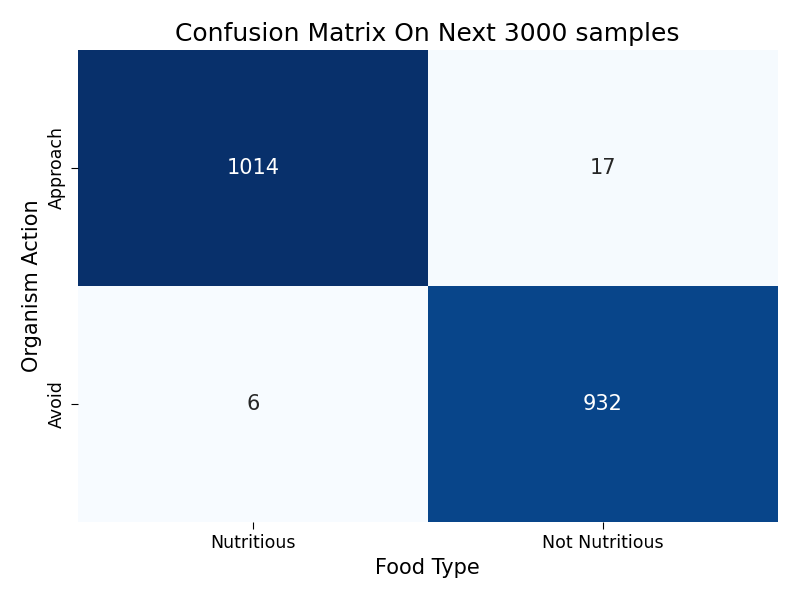

Epoch 0, Iteration 6000: Cum Avg Reward = [1.5534078]


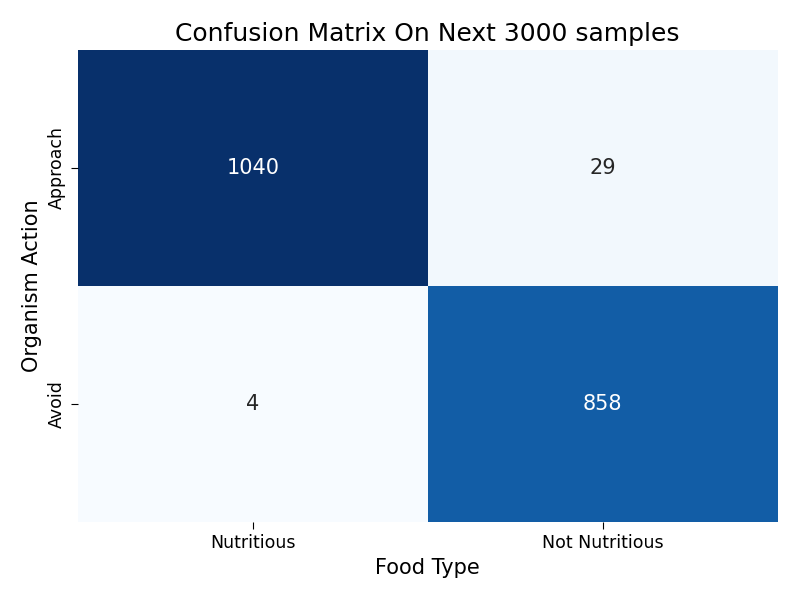

Epoch 0, Iteration 9000: Cum Avg Reward = [1.5721587]


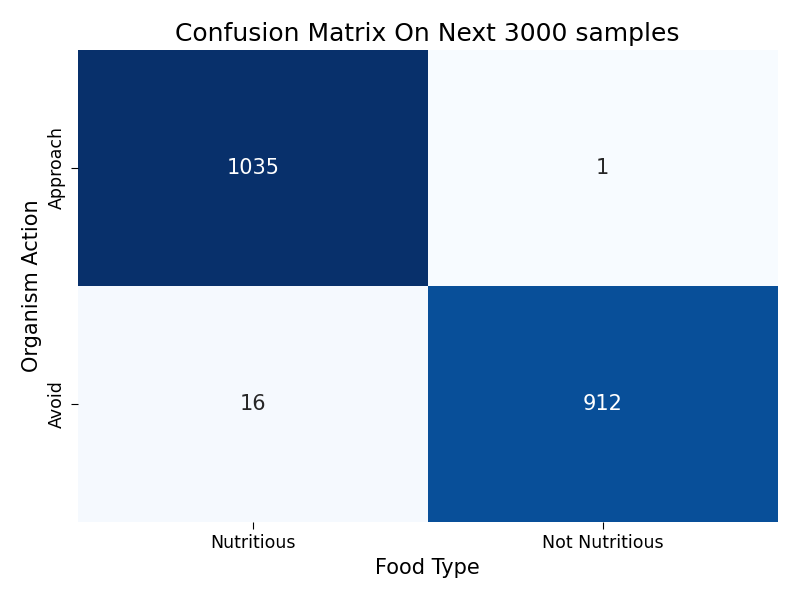

Epoch 0, Iteration 12000: Cum Avg Reward = [1.567786]


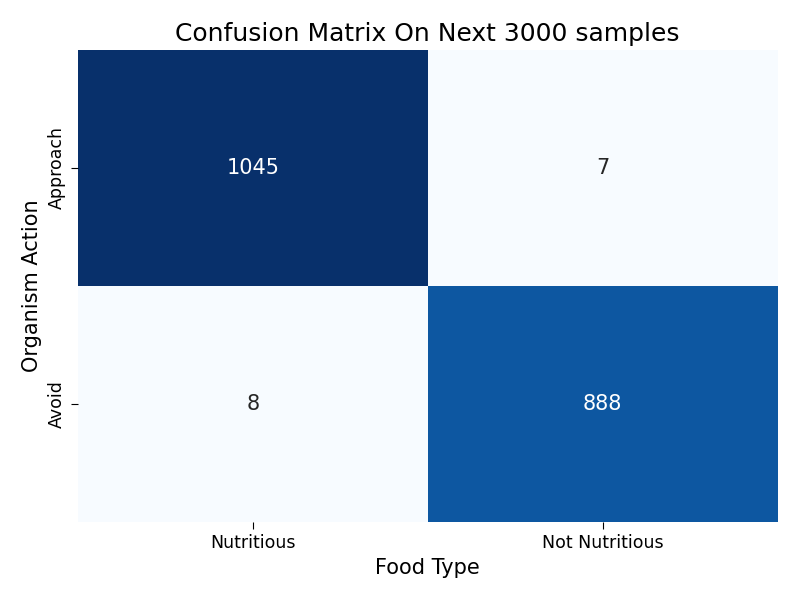

Epoch 0, Iteration 15000: Cum Avg Reward = [1.5756283]


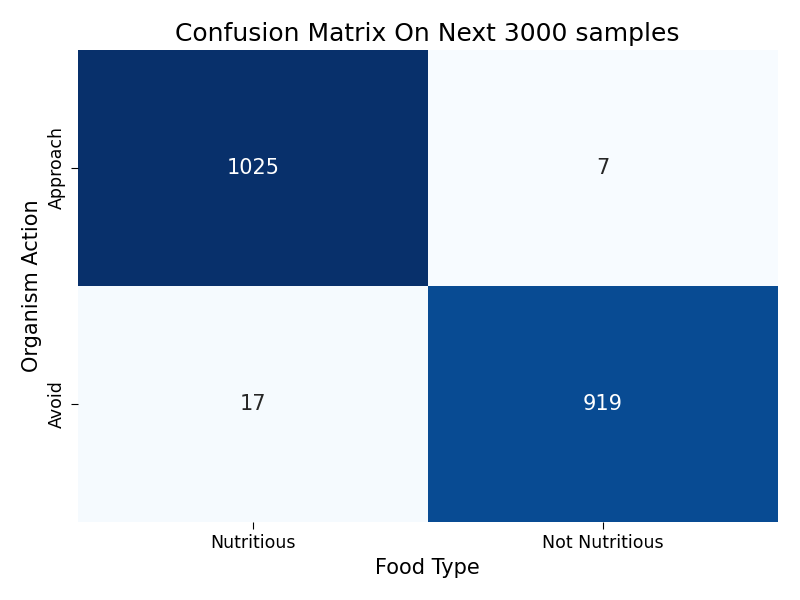

Epoch 0, Iteration 18000: Cum Avg Reward = [1.5749125]


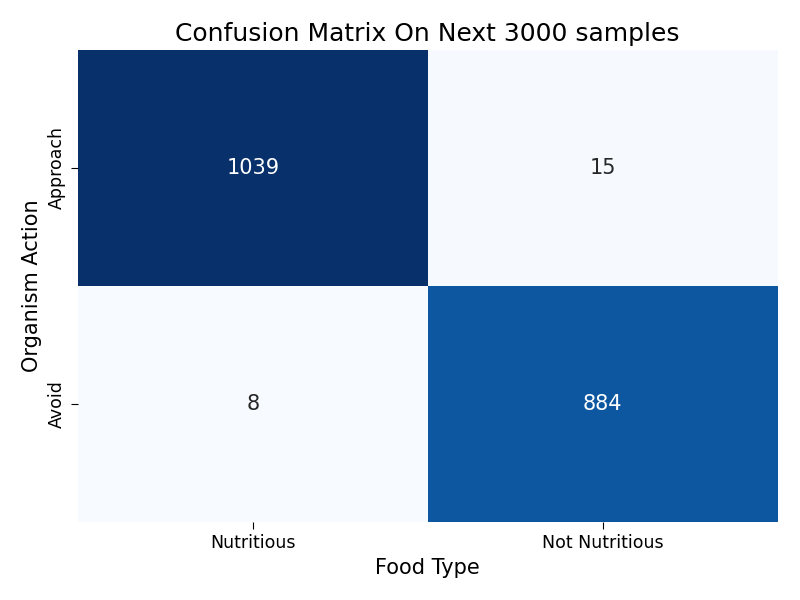

Epoch 0, Iteration 21000: Cum Avg Reward = [1.5738298]


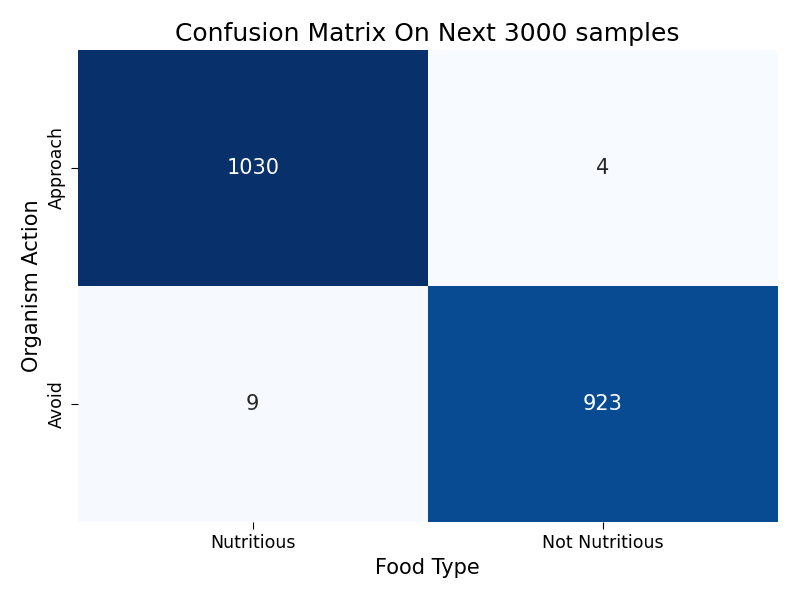

Epoch 0, Iteration 24000: Cum Avg Reward = [1.5747261]


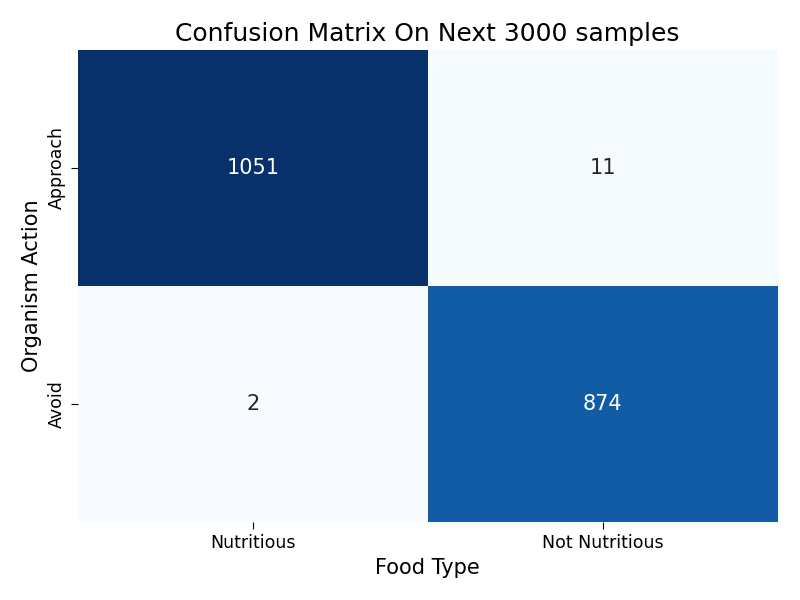

Epoch 0, Iteration 27000: Cum Avg Reward = [1.5771267]


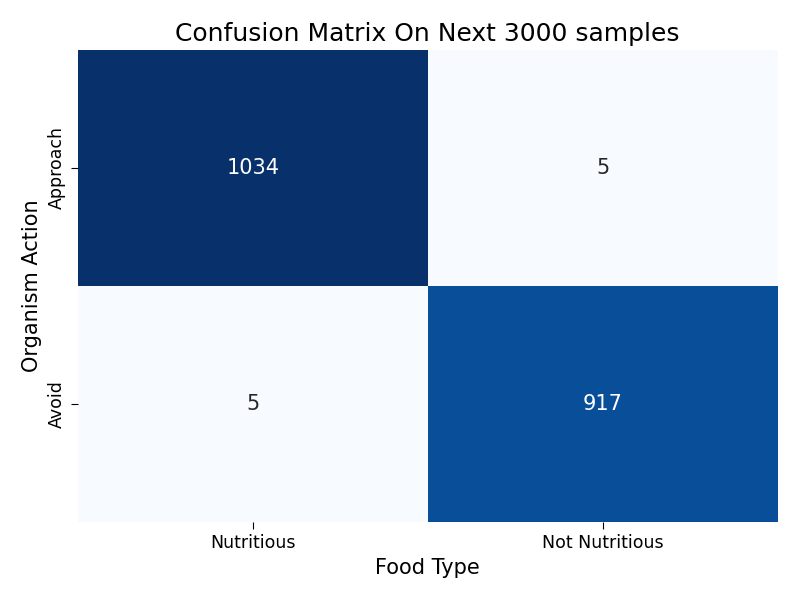

Epoch 0, Iteration 30000: Cum Avg Reward = [1.5765808]


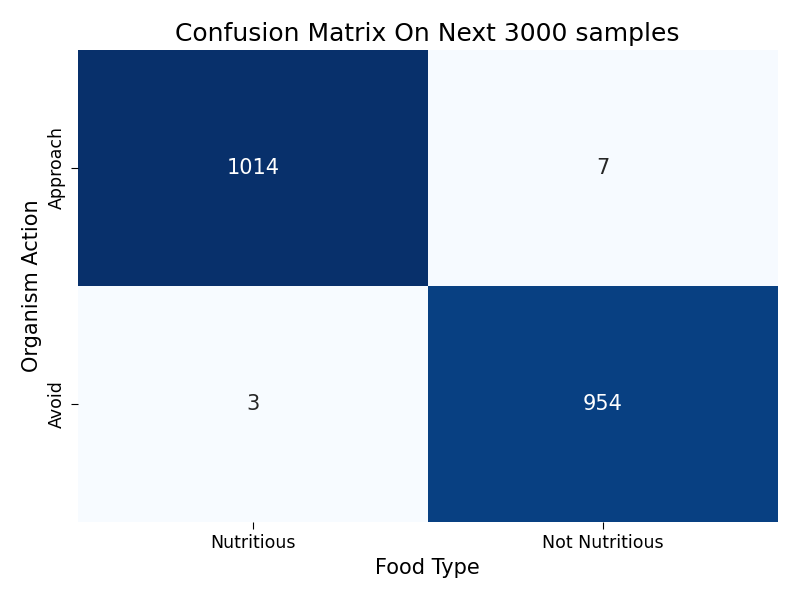

Epoch 0, Iteration 33000: Cum Avg Reward = [1.573316]


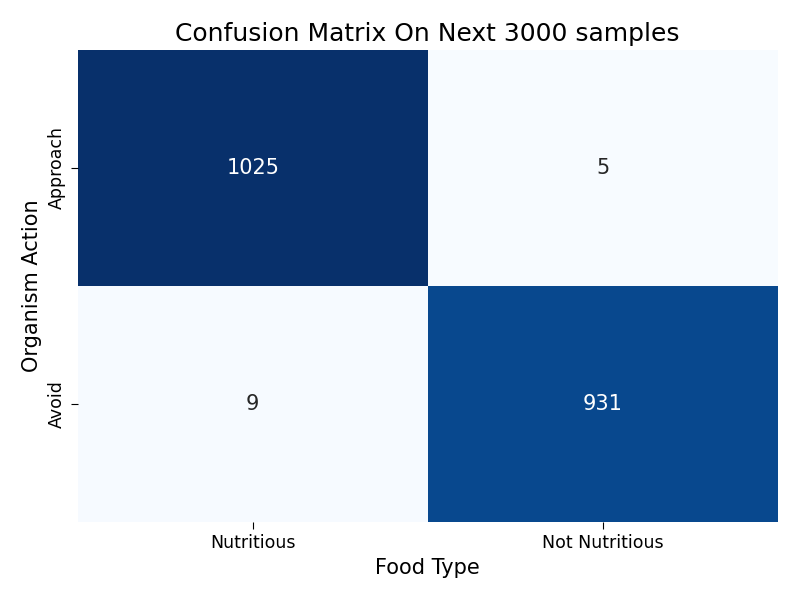

KeyboardInterrupt: 

In [53]:
def eval_plt_cm_s(W1, Ws, W2, rnd_key, X, y):
  TP, FN, FP, TN = eval_policy_s(
    W1, Ws, W2, rnd_key, X, y,
    nutritious_type=1, lifetime=lifetime)
  total_trials = TP + FN + FP + TN
  confusion_matrix = np.array([[TP, FP], [FN, TN]])
  fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
  sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
  # Labels, title and ticks
  column_labels = ['Nutritious', 'Not Nutritious']
  row_labels = ['Approach', 'Avoid']
  ax.set_xlabel('Food Type')
  ax.set_ylabel('Organism Action')
  ax.set_title(f'Confusion Matrix On Next 3000 samples')
  ax.xaxis.set_ticklabels(column_labels)
  ax.yaxis.set_ticklabels(row_labels)
  remove_ip_clutter(fig)
  plt.show()

def train_model(X, y, learning_rate, num_epochs):

  def update_parameters(params, grads, learning_rate):
    return [param_ + learning_rate * grad_ for param_, grad_ in zip(params, grads)]

  nutritious_type = 1
  n_in = 785  # 784 features + 1 bias
  n_hid = 3
  n_out = 2

  # Initialize weights
  rnd_key = jrandom.key(0)
  rnd_key, rs1, rs2, rs3 = jrandom.split(key, num=4)
  W1 = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10
  Ws = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10
  W2 = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10

  indices_0 = jnp.where(y == 0)[0]
  indices_1 = jnp.where(y == 1)[0]
  balanced_epoch = min(len(indices_0), len(indices_1))
  for epoch in range(num_epochs):
    epoch_start_time = time.time()
    # make a balanced epoch of experiences
    rnd_key, shuffle_key0 = jrandom.split(rnd_key)
    shuffled_indices_0 = jrandom.permutation(shuffle_key0, indices_0.shape[0])
    rnd_key, shuffle_key1 = jrandom.split(rnd_key)
    shuffled_indices_1 = jrandom.permutation(shuffle_key1, indices_1.shape[0])
    selected_indices_0 = indices_0[shuffled_indices_0[:balanced_epoch]]
    selected_indices_1 = indices_1[shuffled_indices_1[:balanced_epoch]]
    selected_indices = jnp.concatenate([selected_indices_0, selected_indices_1])
    rnd_key, shuffle_key_final = jrandom.split(rnd_key)
    selected_indices = jrandom.permutation(shuffle_key_final, selected_indices.shape[0])
    X_epoch = jnp.array(X[selected_indices, :])
    y_epoch = jnp.array(y[selected_indices])
    cum_rewards = 0
    for iter_ in range(int(2 * balanced_epoch)):
      X_iter = X_epoch[iter_:iter_+1, :]
      y_iter = y_epoch[iter_:iter_+1]
      # Sample actions and compute rewards
      rnd_key, ra_key = jrandom.split(rnd_key)
      rewards, actions = reward_s(W1, Ws, W2, ra_key, X_iter.T, y_iter, nutritious_type)
      cum_rewards = rewards + cum_rewards
      if iter_ % 3000 == 0:  # Provide feedback every 20 iterations
        print(f"Epoch {epoch}, Iteration {iter_}: Cum Avg Reward = {cum_rewards/(iter_+1)}")
        X_eval = X_epoch[iter_:iter_+3000,:]
        y_eval = y_epoch[iter_:iter_+3000]
        rnd_key, eval_key = jrandom.split(rnd_key)
        eval_plt_cm_s(W1, Ws, W2, eval_key, X_eval, y_eval)
      # Calculate gradients
      W1_grad, Ws_grad, W2_grad = rs_ldp_s_grad(X_iter.T, actions, rewards, W1, Ws, W2)
      # Update parameters
      W1, Ws, W2 = update_parameters([W1, Ws, W2], [W1_grad, Ws_grad, W2_grad], learning_rate)
    print(f"Epoch {epoch}: Cum Avg Reward = {cum_rewards / (2*balanced_epoch)}")

  return W1, Ws, W2

# Set hyperparameters and train the model
X = jnp.array(X_bin_aug1)
y = jnp.array(y_bin_aug)
learning_rate = 0.01
num_epochs = 5
trained_W1, trained_Ws, trained_W2 = train_model(X, y, learning_rate, num_epochs)



In [30]:
X[1:2, :].T.shape

(785, 1)

In [11]:
W1_grad_test.shape

(3, 785)

In [12]:
W1_test.shape

(3, 785)

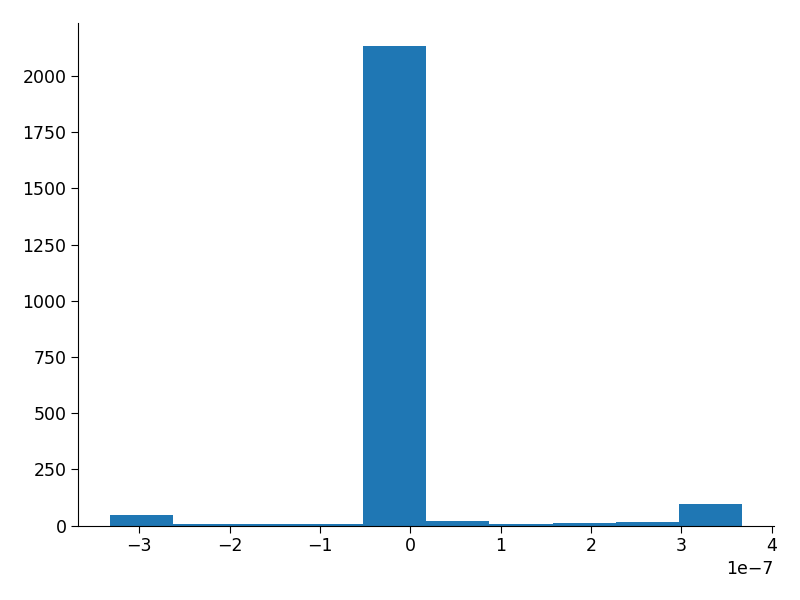

In [15]:
plt.hist(W1_grad_test.flatten())
plt.show()

# 0.1.1.3 Evolving a Good Behavioural Policy in a Changing Environment

In the above exercise we saw that (with a little cheating) an evolutionary process, a simple kind of propose-accept-reject, was able to find relatively good parameter configurations for this simple binary discrimination problem. Now what about when the environment is shifting. The figure below is a result of running the same evolutionary simulations as above, but changing the environment every 30 generations so that what was the nutritrious type of food becomes a waste of time and the waste of time food becomes the nutritious type of food.

In [14]:
#simulation params
num_generations = 40
lifetime = 200
pop_size = 1000
init_nutritious_type = 1
mutation_scale = 0.5
nutritious_type_flip_freq = 10
softmax_selection_strength_temp = 0.5 # close to zero is strong selection, large positive is weak selection
n_in = 65
n_out = 2
n_hid = 3

rnd_key = jrandom.key(0)
population = []

for _ in range(pop_size):
  rnd_key, split_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, split_key))

fitness_history = []
start_time = time.time()
for g in range(num_generations):
  if g % nutritious_type_flip_freq == 0:
    if g == 0:
      nutritious_type = init_nutritious_type
    else:
      nutritious_type = 1 - nutritious_type
  gen_start_time = time.time()
  #everyone in same gen has same experiences
  # move this indices shuffle inside calculate fitness scores to change that
  rnd_key, shuffle_key = jrandom.split(rnd_key)
  shuffled_indices = jrandom.permutation(shuffle_key, X_bin_aug1.shape[0])
  selected_indices = shuffled_indices[:lifetime]
  X_gen = jnp.array(X_bin_aug1[selected_indices, :])
  y_gen = jnp.array(y_bin_aug[selected_indices])
  # calc fitness scores, note no randomness
  fitness_scores = calc_exp_pop_fitness(population, X_gen, y_gen,
                                        nutritious_type, lifetime)
  # store data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q25_fitness': jnp.percentile(fitness_scores, 25).item(),
    'q75_fitness': jnp.percentile(fitness_scores, 75).item()
  })
  current_gen_data = fitness_history[-1]
  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key)
  new_population = []
  for idx in parent_indices:
    rnd_key, mutation_key = jrandom.split(rnd_key)
    new_population.append(mutate(population[idx], mutation_key))
  population = new_population
  # real time feedback on the simulation
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  print(f"Gen: {g+1}/{num_generations} | Mean Score: {current_gen_data['mean_fitness']:.4f} | Score Std Dev: {current_gen_data['std_dev_fitness']:.4f} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q25_fitness = [data['q25_fitness'] for data in fitness_history]
q75_fitness = [data['q75_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness Score', color='blue', linewidth=2)
ax.fill_between(generations, q25_fitness, q75_fitness, color='gray', alpha=0.5, label='Inter-quartile Range')
for g in range(0, num_generations, nutritious_type_flip_freq):
  if g == 0:
    ax.axvline(x=g, color='red', linestyle='--', linewidth=1, label='Environment Change')
  else:
    ax.axvline(x=g, color='red', linestyle='--', linewidth=1)
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()


NameError: name 'calc_exp_pop_fitness' is not defined

Looking at the output of the simulation, we see that on the first and third environmental shifts the population mean fitness score drops drastically, but soon after, the selective process starts to reshape the population's behavioural policy so that nutritious food is eaten instead of avoided. However, after these shifts the evolutionary process is unable to avoid the formerly nutritious but now waste of time food. However, after the second environmental change the population does recover the ability to avoid waste of time food. This is an example of evolutionary history making some kinds of behavioural modifications more or less likely to emerge through mutation and selection. This process where selection causes the population behaviour to change as the environment changes is sometime referred to as evolutionary tracking. Now importantly, because evolution is an inherently reactive process, there will always be a lag between environmental change and recovery of fitness score. And, if the environment is changing rapidly, e.g. every generation, there is no scope for evolutionary tracking. In the simulation below which type of food will be nutritirous or a waste of time is chosen randomly each generation. As a result best policy is simply to always approach all food, since evolution cannot know a priori which type of foods will be nutritious or not.

In [ ]:
#simulation params
num_generations = 18
lifetime = 200
pop_size = 1000
init_nutritious_type = 1
mutation_scale = 0.5
nutritious_type_flip_freq = 3
softmax_selection_strength_temp = 0.5 # close to zero is strong selection, large positive is weak selection
n_in = 65
n_out = 2
n_hid = 3

rnd_key = jrandom.key(0)
population = []

for _ in range(pop_size):
  rnd_key, split_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, split_key))

fitness_history = []
start_time = time.time()
for g in range(num_generations):
  if g % nutritious_type_flip_freq == 0:
    if g == 0:
      nutritious_type = init_nutritious_type
    else:
      nutritious_type = 1 - nutritious_type
  gen_start_time = time.time()
  #everyone in same gen has same experiences
  # move this indices shuffle inside calculate fitness scores to change that
  rnd_key, shuffle_key = jrandom.split(rnd_key)
  shuffled_indices = jrandom.permutation(shuffle_key, X_bin_aug1.shape[0])
  selected_indices = shuffled_indices[:lifetime]
  X_gen = jnp.array(X_bin_aug1[selected_indices, :])
  y_gen = jnp.array(y_bin_aug[selected_indices])
  # calc fitness scores, note no randomness
  fitness_scores = calc_exp_pop_fitness(population, X_gen, y_gen,
                                        nutritious_type, lifetime)
  # store data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q25_fitness': jnp.percentile(fitness_scores, 25).item(),
    'q75_fitness': jnp.percentile(fitness_scores, 75).item()
  })
  current_gen_data = fitness_history[-1]
  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key)
  new_population = []
  for idx in parent_indices:
    rnd_key, mutation_key = jrandom.split(rnd_key)
    new_population.append(mutate(population[idx], mutation_key))
  population = new_population
  # real time feedback on the simulation
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  print(f"Gen: {g+1}/{num_generations} | Mean Score: {current_gen_data['mean_fitness']:.4f} | Score Std Dev: {current_gen_data['std_dev_fitness']:.4f} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q25_fitness = [data['q25_fitness'] for data in fitness_history]
q75_fitness = [data['q75_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness Score', color='blue', linewidth=2)
ax.fill_between(generations, q25_fitness, q75_fitness, color='gray', alpha=0.5, label='Inter-quartile Range')
for g in range(0, num_generations, nutritious_type_flip_freq):
  if g == 0:
    ax.axvline(x=g, color='red', linestyle='--', linewidth=1, label='Environment Change')
  else:
    ax.axvline(x=g, color='red', linestyle='--', linewidth=1)
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

# 0.1.1.4 Learning

# Graveyard

___
## Caution Note: Agent Based Simulations
There are many arbitrary choices to be made about life history that will interact in dramatic and different ways with the core decision problem described above. Seemingly small details in implementation can totally alter the outcome of a simulation. Care must be taken in interpretation. Agent based simulations are not proofs of anything, just a way of illustrating potential implications of different assumptions. They are primarily usefull for illustrating possibilities or hypotheses.
___

o improve an evolutionary processes' efficacy in finding adaptive parameter configurations in the face of environmental stochasticity there are two possible options. The first is to simply increase population size. This has the effect of averaging out the stochasticity of the process, allowing the selective factors to dominated the random factors. In the context of a simulation, increasing the population size is not great though since it will increase computation time linearly. The second option is to reduce the inherent stochasticity of the selection policy. In a simulation context this is more appealing as it can be done very efficiently (from a computational perspective) by directly calculating the expected score of an organism based on its action selection probabilities as contrasted with a calculating a score based on actual selected (sampled) actions and resulting (sampled) reward. We can see what this looks like in the coding exercise below:

## Evolution Box: Drift Barrier Hypothesis

Evolution isn't just about adaptive change, genetic drift is an equally important part of the evolutionary process. One way to think about this
that even as good parameter combinations are being selected for there is a noise floor created the inherent stochasticity of the world which limits the effect of selection. Sometimes an organism makes a lot of babies because it had good genes that helped it to have a body and engage in behaviours that were well suited to its ecological niche, other times though organism was just in the right place at the right time, and its success had much more to do with happenstance than genetic variance from conspecifics. When the former dominates the selective process we expect organisms to be relatively well fit to their ecological niche, but when random happenstance dominates, we do not expect such a good fit to ecological niche. In the later case "just because that's how it happened" can often be the correct explanation for why an organism is a certain way. Not everything is an adaption, some things are primarily quirks of history. The evolved organisms and their traits that we observe in the world are of course shaped by both processes simultaneously. The drift barrier hypothesis states that there are hard limits to how 'perfected' a trait can become given the stochasticity inherent in selection.

## Coding Exercise: Implement Deterministic - Expected Value - Behaviour Policy Evaluation

In [ ]:
@jit
def approx_exp_eval_policy(W1, Ws, W2, X, y, nutritious_type):
  # The opportunity costs of false positives are relative to the expected
  # rate of return on foraging time given the policy. If we assume perfect
  # discrimination and an even distribution of nutritrious and non-nutritious
  # foods then then a perfect organsim gets one fitness score point every three
  # time units. This means the opportunity cost of approaching non-nutritrious
  # foods is 1/3. If the organism had an approach everything policy they would
  # get one fitness score point every four times units and so the opportunity
  # cost
  x_batch = X.T  # n_in x batch
  probs = calc_decision_probs(x_batch, W1, Ws, W2)  # probs is n_out x batch
  was_nutritious = y == nutritious_type  # batch
  was_waste = y != nutritious_type  # batch
  prob_approach = probs[0, :]  # Probability of 'approach' action
  prob_avoid = probs[1, :]     # Probability of 'avoid' action
  batch_TP = jnp.where(was_nutritious, prob_approach, 0)
  batch_FP = jnp.where(was_waste, prob_approach, 0)
  batch_FN = jnp.where(was_nutritious, prob_avoid, 0)
  batch_TN = jnp.where(was_waste, prob_avoid, 0)
  TP = jnp.sum(batch_TP)
  FP = jnp.sum(batch_FP)
  FN = jnp.sum(batch_FN)
  TN = jnp.sum(batch_TN)
  score = TP - (FP/3)
  return score, TP, FN, FP, TN

def calc_exp_pop_fitness(population, X_gen, y_gen, nutritious_type):
  fitness_scores = jnp.zeros(len(population))
  for i, critter in enumerate(population):
    fitness_scores = fitness_scores.at[i].set(
      approx_exp_eval_policy(
        critter['W1'], critter['Ws'], critter['W2'],
        X_gen, y_gen,
        nutritious_type
      )[0] # Assuming this returns a scalar fitness value
    )
  return fitness_scores

#simulation params
num_generations = 80
lifetime = 300
approx_lifetime = int(lifetime * 2 / 3)
pop_size = 500
nutritious_type = 1
mutation_scale = 0.01
softmax_selection_strength_temp = 0.5 # close to zero is strong selection, large positive is weak selection
n_in = 65
n_out = 2
n_hid = 3

rnd_key = jrandom.key(0)
population = []

for _ in range(pop_size):
  rnd_key, split_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, split_key))

fitness_history = []
start_time = time.time()
best_params = DotDict({})
for g in range(num_generations):
  gen_start_time = time.time()
  #everyone in same gen has same experiences
  # move this indices shuffle inside calculate fitness scores to change that
  rnd_key, shuffle_key = jrandom.split(rnd_key)
  shuffled_indices = jrandom.permutation(shuffle_key, X_bin_aug1.shape[0])
  selected_indices = shuffled_indices[:lifetime]
  X_gen = jnp.array(X_bin_aug1[selected_indices, :])
  y_gen = jnp.array(y_bin_aug[selected_indices])
  # calc fitness scores, note no randomness
  fitness_scores = calc_exp_pop_fitness(population,
                                        X_gen[:approx_lifetime],
                                        y_gen[:approx_lifetime],
                                        nutritious_type,)
  rnd_key, fit_key = jrandom.split(rnd_key)
  rnd_fitness_scores = calc_pop_fitness(population, X_gen, y_gen,
                                        nutritious_type, lifetime, fit_key)
  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key)
  unique_parents_count = len(jnp.unique(parent_indices))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = population[best_idx]  # Retrieve the best individual's parameters
  new_population = []
  for idx in parent_indices:
    rnd_key, mutation_key = jrandom.split(rnd_key)
    new_population.append(mutate(population[idx], mutation_key, mutation_scale))
  population = new_population
  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'rnd_mean_fitness': jnp.mean(rnd_fitness_scores).item(),
    'std_dev_fitness': jnp.std(rnd_fitness_scores).item(),
    'q25_fitness': jnp.percentile(rnd_fitness_scores, 25).item(),
    'q75_fitness': jnp.percentile(rnd_fitness_scores, 75).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  print(f"Gen: {g+1}/{num_generations} | Sel Score: {current_gen_data['mean_fitness']:.4f} | Avg Score: {current_gen_data['rnd_mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['rnd_mean_fitness'] for data in fitness_history]
q25_fitness = [data['q25_fitness'] for data in fitness_history]
q75_fitness = [data['q75_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness', color='blue', linewidth=2)
ax.fill_between(generations, q25_fitness, q75_fitness, color='gray', alpha=0.5, label='Inter-quartile Range')
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN = eval_policy(
  best_params.W1, best_params.Ws, best_params.W2, eval_key, X_gen, y_gen,
  nutritious_type=nutritious_type, lifetime=200)
total_trials = TP + FN + FP + TN
confusion_matrix = np.array([[TP, FP], [FN, TN]])
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
# Labels, title and ticks
column_labels = ['Nutritious', 'Not Nutritious']
row_labels = ['Approach', 'Avoid']
ax.set_xlabel('Food Type')
ax.set_ylabel('Organism Action')
ax.set_title(f'Confusion Matrix Of Most Fit Organism in Last Generation')
ax.xaxis.set_ticklabels(column_labels)
ax.yaxis.set_ticklabels(row_labels)
remove_ip_clutter(fig)
plt.show()

So when we cheat like this and let evolution act on the true 'expected score', then evolution is able to find a good solution relatively quickly. Now let's take a look at how this evolutionary process responds to a changing environment

So unfortunately and it will take a very long time for this process of selection on random variation to find a policy better than the one it discovers quickly after just a few generations. The real challenge for this selection mutation process in finding a good parameter setting for the behaviour policy is the inherently stochastic nature of the evaluation function. In particular, even if one organism has a set of parameters that is objectively 'better' in the sense that on average it will achieve a higher score, given the randomness in both the particular set of experiences encountered, and the probabalistic selection of actions by the policy, parameters which are strictly 'better' may never-the-less not have the highest realized fitness score.

Note that when the organism has an equal proabibility of striking everything the expected score is 50, whereas an organism with the "eat everything" policy has an expected score of 75. Looking at the confusion matrix of the most fit organism in the last generation of this simulation we see that although the average score isn't much better than the 75 that can be achieved by eating everything, eat everything is clearly not the behavioural policy that this evolutionary policy has discovered, rather a pretty good, but ultimately imperfect attempt at discrimination is being made. An organism with a perfect policy that approaches all nutritious food and avoids all waste of time food has an expected score of 100.

One of many reasons that it is difficult for this evolutionary process to improve much beyond this level of performance is that to achieve better discrimination the parameters of the behavioural function need to be co-adapted, i.e. work together to support non-linear combinations of the basic sensory features. Finding such complex co-adaptions with random perturbations is like finding a needle in a haystack and can take a very long time. In the next section we see how the idea of gradients can help to coordinate updates in parameters, making these complex co-adaptations more easy to discover.

In [ ]:
def eval_dec_func_one_sample(TP, FP, TN, FN, time_used,
                             W1, Ws, W2,
                             rnd_key, x_i, y_i, nutritious_type):
  # what does the organism do
  sample, _ = make_decision(x_i, W1, Ws, W2, rnd_key)
  # how much time does it take
  time_inc = 1 + (sample[0] == 0)
  time_used += time_inc
  # is it TP (eat nutritious food), FP (eat waste of time food),
  # FN (avoid nutritious food), TN (avoid wast of time food)
  is_nutritious = y_i[0] == nutritious_type
  is_waste = y_i[0] != nutritious_type
  did_eat = sample[0] == 0
  did_avoid = sample[0] == 1
  TP += is_nutritious * did_eat
  FP += is_waste * did_eat
  FN += is_nutritious * did_avoid
  TN += is_waste * did_avoid
  return (TP, FN, FP, TN, time_used)

def evaluate_decision_function(W1, Ws, W2, #jnp arrays params of decision function
                               rnd_key, #jrandom.key
                               X, #array batch x n_in
                               y, #array batch
                               nutritious_type, # integer label
                               lifetime): #postive integer
  time_used = 0
  nutritous_food_approached = 0
  nutritous_food_avoided = 0
  waste_of_time_food_approached = 0
  waste_of_time_food_avoided = 0
  # Iterate through examples until time units are exhausted
  for i in range(y.shape[0]):
    if time_used >= lifetime:
      break
    # the situation
    x_i = X[i].reshape(-1,1) # n_in x batch
    y_i = y[i].reshape(1,-1) # 1 x batch
    rnd_key, sub_key = jrandom.split(rnd_key)
    (nutritous_food_approached,
     nutritous_food_avoided,
     waste_of_time_food_approached,
     waste_of_time_food_avoided,
     time_used,) = eval_dec_func_one_sample(
        nutritous_food_approached,
        waste_of_time_food_approached,
        waste_of_time_food_avoided,
        nutritous_food_avoided,
        time_used,
        W1, Ws, W2,
        sub_key, x_i, y_i, nutritious_type
    )
  return (nutritous_food_approached, nutritous_food_avoided,
          waste_of_time_food_approached, waste_of_time_food_avoided)


**Math Exercise**
1. Use the calculus principles we've discussed and apply them to derive a general formula for finding the maxima or minima of any parabola, parameterized by coefficients $a$, $b$, and $c$ as

$$f(x) = a(x-b)^2 + c$$

(Answer: The vertex of the parabola, occurring at $x=b$, is either the global maximum or minimum value. Whether it is a maximum or minimum is determined by the curvature of the parabola, which is given by coefficient $a$. Specifically, the vertex represents a minimum when $a$ is positive and the parabola opens upwards, and a maximum when $a$ is negative and the parabola opens downwards. The value at this vertex, $f(b) = c$, is thus either the maximum or minimum value depending on $a$'s sign. Virtually all practical optimizations problems involve constraints. With $x$ constrained to an interval, two possible cases arise. First, if the vertex falls outside this interval, both the maximum and minimum values within the constraints will occur at the boundary points. Second, if the vertex falls within the constrained interval, then either the vertex is a minimum (with $a$ positive) and the maximum value of the function will be found at a boundary point, or the vertex is a maximum (with $a$ negative) and the minimum value will similarly be located at the boundary.)


In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Optimizing a Polynomial with Propose and Reject
Now, the analytic method above of taking derivatives, finding zeros, and checking concavity offers a clear solution to optimization problems. However, these sorts of computations are unlikely to serve as model of low level neural plasciticty, for several interelated reasons having to do with scalability, complexity, and information requirements, each of which we will unpack in more detail later. For now we take as given that something like analytic optimization is likely not what is happening in the brain. This raises the question of whether there are other more simple methods for solving this kind of problem, methods that are more likely to have clearer correspondence witht the physilology of th brain.

One of the simplest optimization strategies that exists, and one that proved quite effective earlier in this book, is propose and reject. Indeed, evolution through natural selection is roughly running a kind of propose (new variants through mutation and recombination) and accept or reject (through selective survival and reproduction) algorithm on the living world. To further develop our intuitions, let's apply this approach to our familiar optimization challenge of finding the value of $x$ that maximizes a quadratic function $f(x)$.

Propose and reject algorithms offer a conceptual simplicity that makes them easier to envision as mechanisms within the brain. Imagine synaptic weights between neurons undergoing slight, temporary adjustments. If these adjustments yield a positive outcome, they are reinforced and made more permanent, laying the groundwork for future experimentation. This is, admittedly, an oversimplification, but it outlines a process that aligns more closely with what is known of the underlying physiology of neural plasticity at the micro level and behavioural plasticity at the macro level: iterative, trial and error learning.

Below, is an interactive implementation of the propose-and-reject method applied to finding the maximum of a quadratic function. Stepping through the process will give a feel for the iterative nature of decision-making. Start by clicking 'Propose' to sample a new proposed $x$ value. Then, decide whether to 'Accept' or 'Reject' the proposed point based on a comparison with the previous point. Your goal is to find the peak of the curve. 'Show History' is turned on to start so you can see all of the previous steps in the process. You can toggle the 'Show Function' button to plot the polynomial we are optimizing.

In [ ]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept', disabled=True)
    self.reject = widgets.Button(description='Reject', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.accept, self.reject]),
        self.full_step,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.full_step.on_click(lambda btn: asyncio.create_task(self.on_full_step_clicked(btn)))
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.ax.set_xlabel('x')
    self.ax.set_ylabel('f(x)')
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output()
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click 'Accept' or 'Reject' to accept or reject this proposed x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.accept.disabled = False
    self.reject.disabled = False
    self.propose.disabled = True
    self.full_step.disabled = True

  def on_accept_clicked(self, button):
    with self.narration_display:
      clear_output()
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.proposed_x = None
    self.proposed_y = None
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.full_step.disabled = False

  def on_reject_clicked(self, button):
    with self.narration_display:
      clear_output()
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.full_step.disabled = False

  async def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.on_propose_clicked(button)  # Simulate a proposal
    self.accept.disabled = True
    self.reject.disabled = True
    #await asyncio.sleep(2)  # Non-blocking wait for 1 second to allow UI to update
    if self.proposed_y > self.current_y:
        self.on_accept_clicked(button)
    else:
        self.on_reject_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

So propose and reject works pretty well, but there is a notable limitation. Whenever the proposed step is in the 'wrong' direction, we don't make any progress towards a better $x$ value. Although propose and reject has a nice ratcheting feature—that is, we never pick an $x$ value that is worse than the one we currently have—we can potentially waste a lot of evaluations on test steps in the wrong direction. To overcome this limitation, we can introduce a tweak: making updates in the opposite direction of a 'wrong' step. This tweak shifts our evaluative question from 'Is this a good new point to jump to?' to 'In which direction should I change the parameter?'. This shift helps us avoid 'wasting' unfavorable proposals. Specifically, by using every proposal—favorable or not—for guidance, this method ensures that each test step, regardless of its initial direction, contributes valuable information for parameter adjustment. However, this leaves open the question of how far to step in that opposite direction. For now, let's just try stepping as far as the initially proposed step but in the opposite direction. You can try out this modified version of the algorithm in the interactive widget below.

In [ ]:
# @title Manual Optimization with Modified Propose and Reject (always step)
# @markdown **Run this cell** to try your hand at manually finding the maximum of a quadratic function with this modified Propose and Reject method.
class InteractivePolynomialTestStep:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-4, 4),
               step_size=0.5, seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 4
    self.bounds = bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.proposals_evaluated = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.take_step = widgets.Button(description='Take Step')
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.take_step.disabled = True  # Disable since there's no proposal initially
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.take_step]),
        self.full_step,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.take_step.on_click(self.on_take_step_clicked)
    self.full_step.on_click(lambda btn: asyncio.create_task(self.on_full_step_clicked(btn)))
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'rx', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.ax.set_xlabel('x')
    self.ax.set_ylabel('f(x)')
    self.fig.canvas.draw_idle()

  def on_propose_clicked(self, button):
    self.proposals_evaluated += 1
    perturbation = self.rng.standard_normal() * self.step_size
    self.proposed_x = self.current_x + perturbation
    self.proposed_y = self.polynomial(self.proposed_x)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()
    #self.update_plot()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print("Click 'Take Step' to update x?")
      print(f'Proposals evaluated so far: {self.proposals_evaluated}')
    self.take_step.disabled = False
    self.propose.disabled = True
    self.full_step.disabled = True

  def on_take_step_clicked(self, button):
    if self.proposed_y > self.current_y:
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is better stepping to proposed')
        print(f'Step to x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}.')
        print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
        print(f'Points evaluated so far: {self.proposals_evaluated}')
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = self.proposed_x
      self.current_y = self.proposed_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    elif self.proposed_y < self.current_y:
      mirror_x = self.current_x - (self.proposed_x - self.current_x)
      mirror_y = self.polynomial(mirror_x)
      self.proposals_evaluated += 1
      with self.narration_display:
        clear_output(wait=True)
        print('Proposed is not as good as current, going in the opposite direction.')
        print(f'Step to x: {mirror_x:.3f}, y: {mirror_y:.3f}.')
        print(f'Points evaluated so far: {self.proposals_evaluated}')
        print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      self.x_history.append(self.current_x)
      self.y_history.append(self.current_y)
      self.current_x = mirror_x
      self.current_y = mirror_y
      self.proposed_x = None
      self.proposed_y = None
      self.point_current.set_data([self.current_x], [self.current_y])
      self.points_history.set_data(self.x_history, self.y_history)
      self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()
    self.take_step.disabled = True
    self.propose.disabled = False
    self.full_step.disabled = False

  async def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.on_propose_clicked(button)  # Simulate a proposal
    #await asyncio.sleep(1)  # Non-blocking wait for 1 second to allow UI to update
    self.on_take_step_clicked(button)  # Simulate a step

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.proposed_x = None
    self.proposed_y = None
    self.x_history = []
    self.y_history = []
    self.take_step.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ipts = InteractivePolynomialTestStep()
display(ipts.fig.canvas)
clear_output()
display(ipts.ui)

This modified propose and reject is likely more efficient at first, especially in moving quickly towards the general area of the maximum. However, an issue arises near the maximum value: the risk of "over-shooting" increases, and unlike the original version of propose and reject, this always steo method can sometimes step to worse $x$ values because it lacks a strict ratcheting mechanism. One way to mitigate this issue is to fiddle with step size, but in doing so we will always face a tradeoff. Large step sizes are helpful in the beginning to quickly get into the rough neighbourhood of the maximum and smaller step sizes are better once we are close to the maximum to dial in the maximum precisely. However, without a sense of how close or far away the maximum is, it is difficult to choose an appropriate step size.

Also note that when we step in the opposite direction of the initial proposal, an additional function evaluation is required since this new point is not the same as the proposed point. So even though we take a step as result of every proposal, an additional function evaluation is required whenever we step in the opposite direction of the proposal.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3 Optimizing a Polynomial with Perturb-Measure-Step

One way to get around the limitations we've encountered in propose and reject (and modified propose and reject) is to dive a little deeper into the insights possible from evaluating proposed values. Previously, with propose and reject, we only ask, "Is this better?" in modified propose and reject, this becomes "Is this the correct direction for our step?" However, we can pose and answer a much more sophisticated question using the same information: "Given the comparison of this proposed $x$ to the current value, how does $f(x)$ change with $x$ near our current position, and based on this, ***in which direction and how far*** should we step?" Essentially, this boils down to assessing the slope of the line connecting our current and proposed points and then updating $x$ in a direction proportional to this slope. In this way, the slope informs us not only about the direction but also about the appropriate distance of our update. We call this the perturb-measure-step approach.

In this approach we ***measure*** the relationship between the change in the performance and the change in the parameter using a small perturbation as a test point. The update applied is then ***proportional*** to the ***measured performance changes*** over the ***measured parameter changes***, i.e. an estimate of the rate of change in performance for changes in the parameters or the slope. As a word equation

$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality in this case usually called the learning rate or step-size meta-parameter of the learning algorithm. In the case of optimizing a function $f(x)$ this gives us


$$x_{t+1} = x_t + \alpha \cdot \frac{f(x_t + \Delta) - f(x)}{\Delta}$$

Where $\Delta$ is the small test pertubation applied to $x$ to measure the slope.

On the one hand we might expect a 'measure and update' method to be more efficient than a 'propose and reject' method, because with a 'propose and reject' algorithm we don't make any parameter updates unless 'better' parameters are proposed. This means that most of the information from evaluation is thrown away every time parameters are rejected. In contrast, a 'measure and update' method will always updated the parameters using the information gleaned from the tested parameters. Note that because of this, in the propose and reject method, the test point step size and the parameter update step size are one and the same. In contrast in the perturb-measure-step approach the test step $\Delta$ and the scaling factor of the step size $\alpha$ are different quantities.

Use the interactive widget below to step through the perturb-measure-step process we've outlined to see how the slope between the current point and a test point can efficiently guide parameter updates.

In [ ]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the maximum of a quadratic function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               polynomial_max = 1,
               bounds=(-2, 2),
               test_step_size=0.1,
               x_step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.polynomial_max = polynomial_max
    self.polynomial = lambda x: -(x - polynomial_max)**2 + 5
    self.bounds = bounds
    self.test_step_slider = widgets.FloatSlider(value=test_step_size, min=-0.5, max=0.5, step=0.01,
                                                    description='Test Step:', readout=True, readout_format='.2f')
    self.x_step_slider = widgets.FloatSlider(value=x_step_size, min=0.01, max=1.5, step=0.01,
                                                    description='x Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure', disabled=True)
    self.step = widgets.Button(description='Step', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=False, description='Show Function')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.full_step,
        self.test_step_slider,
        self.x_step_slider,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.full_step,
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.x_step_slider.observe(self.on_x_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def on_x_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(x_vals, y_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_y - self.slope * self.current_x
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test x: {self.test_x:.3f}, y: {self.test_y:.3f}.')
      print(f'Current x: {self.current_x:.3f}, y: {self.current_y:.3f}.')
      print(f'Points evaluated so far: {self.points_tested}')
      print("Click 'Measure' to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_y - self.current_y
    run = self.test_x - self.current_x
    self.slope = rise / run
    self.y_intercept = self.current_y - self.slope * self.current_x
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.slope * x_vals + self.y_intercept
    self.step_line.set_data(x_vals, y_vals)
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_x:.3f} to {self.step_x:.3f}')
      print("Click 'Step', to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    self.points_tested += 1
    new_y = self.polynomial(self.step_x)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x: {self.step_x:.3f}')
      print(f'Actual y value there is {new_y:.3f}')
      print(f'Points evaluated so far: {self.points_tested}')
      print(f"Click 'Perturb' to test a new value.")
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.step_x
    self.current_y = new_y
    self.point_current.set_data([self.current_x], [self.current_y])
    self.test_x = None
    self.test_y = None
    self.test_point.set_data([], [])
    self.step_x = None
    self.step_y = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False
    self.full_step.disabled = False

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button)
    self.on_measure_clicked(button)
    self.on_step_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.polynomial_max = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.polynomial = lambda x: -(x - self.polynomial_max)**2 + 5
    x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    y_vals = self.polynomial(x_vals)
    self.line_polynomial.set_data(x_vals, y_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    padding = (max_y - min_y) * 0.1  # Add some padding to the limits
    self.ax.set_ylim(min_y - padding, max_y + padding)
    self.current_x = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_y = self.polynomial(self.current_x)
    self.test_x = None
    self.test_y = None
    self.step_x = None
    self.step_y = None
    self.x_history = []
    self.y_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

Wow, that works great. We consistently move in the correct direction: taking larger steps when we're further from the maximum and gradually reducing our step size as we approach it. This ensures that even if we overshoot, we're never too far from the maximum, minimizing any potential backtracking. Note though that because we are never stepping to exactly our test point, each iteration requires two function evaluations, one to evaluate the new current location and another to evaluate the test point, that will inform the next step.

For those with a background in calculus, the success of this method might not come as a surprise. The slope between two closely spaced test points serves as an approximation of the derivative. By aligning our step sizes with this slope—both in magnitude and direction—we effectively harness the principle of gradient ascent, which naturally leads to smaller steps as we near the peak. This gradient-based approach ensures continuous progress towards a maximum, with the rare exceptions of slight overshoots when we're very close to the maximum goal. Fortunately, even these overshots are corrected in subsequent steps, given sufficiently small test and parameter step sizes.

To get a sense of how both test step size and parameter step size impact the rate of convergence on the maximum, use the sliders to play with these two different meta-parameters of the optimization process in the widget below.

In [ ]:
# @title Playing with step sizes in Perturb-Measure-Step
# @markdown **Run this cell** to play with the effect of step-size on the perturb-measure-step approach.
ipss2 = InteractivePolynomialSlopeStepper(adjustable_step_size=True)
display(ipss2.fig.canvas)
clear_output()
display(ipss2.ui)

**Exploration Exercise:**

In the widget above, adjust the `x Step` and `Test Step` size sliders to explore the following scenarios:
1. **Gradual Approach without Overshooting:** Adjust the step sizes so that the current value of $x$ slowly approaches the maximum without overshooting. Aim for a scenario where $x$ gets increasingly closer to the maximizing value but never quite reaches or surpasses it.
2. **Controlled Chattering:** Set the step sizes to allow the current value of $x$ to slowly approach the maximum but with overshoots in each iteration (after possibly a few initial iterations). This behavior, known as chattering, can still be acceptable as long as the process is overall converging on the optimal value.
3. **Unstable Chattering:** Adjust the steps to cause the value of $x$ to consistently overshoot and end up further away from the optimal value with each iteration. This scenario represents unstable chattering, which prevents the optimization process from maintaining $x$ close to the optimal value.

**Hint:** Click the "Show Function" button to see the curve you're optimizing against. Visualizing the function can provide valuable insights into how different step sizes affect the optimization journey towards the maximum.


Now that we've covered some foundational optimization ideas, we can start to consider how these ideas might be applied to the learning challenges faced by organisms—and, more specifically, their brains—in the natural world. We'll start with applying these ideas in simple, illustrative scenarios that roughly abstract the types of challenges living organisms navigate in their quest to survive and thrive. We will still be a long way off from anything a brain is likely to be doing, but this is good step towards bridging the gap between abstract optimization and tangible, adaptive neural plasticity.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

#2.1.1.4: Optimizing Behaviour with Perturb-Measure-Step: The Optimal Striking Threshold

In previous chapters we motivated much of our modeling using a binary classification problem in which a lurking predator must choose between striking and not striking based on sensory input. Initially, we viewed the behavioral map from sensory input to action as genetically determined. However, we concluded the chapter on evolution by highlighting the evolutionary advantage of at least partially learning these sensory-behaviour maps within an organism's lifetime. These advantages emerge in part due to variable environments and complex behaviors with non-linear fitness impacts.

Here we shift our focus and work with the case where the behavioural map from sensory input to action is to be entirely 'learned' by the organism, using feedback signals from the environment. We will use and extend the fundamental optimization concepts just introduced. But, before we build a highly abstracted model of a neural circuit together with a learning/optimization rule to solve this problem, let's see if your neural network is up to the task. In the simulation below, given a sensory input pattern, decide whether to strike or not. Try to maximize your average score and see how well you can perform. We will start with a very simple 'sensory' pattern.


For us at least, this task wasn't too hard. The simple association - strike when the center pixel is relatively light, don't strike when the center pixel is dark - works well. We can learn this association with our eyes and brains. Now, let's see if we can take our perturb-measure-step idea from above and adapt it into a model that learns to appropriately strike and not strike. The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). Let's take a quick look at the data before we start coming up with a way to correctly distinguish between the strike and no-strike cases.

In [ ]:
# What is the shape and type of the data we have to work with
print(f'Input data type: {type(X_simple_1_feature)}')
print(f'Input data shape: {X_simple_1_feature.shape}')
print(f'Output target data type: {type(y1_simple.dtype)}')
print(f'Output target shape: {y1_simple.shape}')

This data set consist of 1125 distinct $(\text{input}, \text{output})$ pairs. The goal of the organism is to learn as quickly as possible to correctly distinguish between these two different kinds of situation.

In [ ]:
# what do the ouptus look like, what is their range
print(y1_simple[:10])
print(f'max output value: {np.max(y1_simple)}')
print(f'min output value: {np.min(y1_simple)}')

In the interactive strike-no-strik setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [ ]:
# what do the inputs look like, what is there range
print(X_simple_1_feature[:10])
print(f'Max input value: {np.max(X_simple_1_feature)}')
print(f'Min input value: {np.min(X_simple_1_feature)}')

In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker center pixels. Now that we have a sense of the type and range of the input and output pairs let's visualize the whole dataset. For a simple dataset like this we can visualize the distribution of the input values conditional on the two different "correct" outputs.

In [ ]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
remove_ip_clutter(fig)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

Looking at the distribution of the input values across these two classes (strike vs. no-strike situations), we see that we should be able to correctly discriminate between these two cases most of the time. Perhaps the simplest decision rule that could be used in a situation like this is a 'threshold' decision rule. Looking at the histograms above, a good threshold would be one where the organism strikes if the input value is above the threshold and does not strike if the input value is below the threshold. For now we leave aside how an organism might actually learn such a threshold from experience, and simply ask, what is the optimal such threshold value, given this particular set of $\text{input}, \text{output}$ pairs. Use the widget below to dial in the optimal threshold given this particular data-set and payoff function.


In [ ]:
# @title Dialing in The Optimal Threshold
# @markdown **Run this cell** to manually dial in the optimal threshold
class InteractiveThresholdDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r_slider = widgets.FloatSlider(
        value=1, min=0.5, max=2, step=0.25,
        description='Strike:', readout=True, readout_format='.2f')
    self.false_strike_r_slider = widgets.FloatSlider(
        value=-1, min=-2, max=-0.5, step=0.25,
        description='Miss:', readout=True, readout_format='.2f')
    self.non_strike_r_slider = widgets.FloatSlider(
        value=0, min=-1, max=1, step=0.25,
        description='Lurk:', readout=True, readout_format='.2f')
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.threshold_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Threshold:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax) = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([widgets.VBox([self.threshold_slider,
                                    self.correct_strike_r_slider,
                                    self.false_strike_r_slider,
                                    self.non_strike_r_slider]),
                      self.narration_display])
    ])
    self.threshold_slider.observe(self.on_slider_changed, 'value')
    self.correct_strike_r_slider.observe(self.on_slider_changed, 'value')
    self.false_strike_r_slider.observe(self.on_slider_changed, 'value')
    self.non_strike_r_slider.observe(self.on_slider_changed, 'value')
    print("We have narration display", hasattr(self, 'narration_display'))


  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r_slider.value * np.sum(correct_strikes, axis=0) +
         self.false_strike_r_slider.value * np.sum(false_strikes, axis=0) +
         self.non_strike_r_slider.value * np.sum(correct_non_strikes, axis=0) +
         self.non_strike_r_slider.value * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
      # for single threshold evaluations
      num_correct_strikes = np.sum(correct_strikes)
      num_false_strikes = np.sum(false_strikes)
      num_correct_non_strikes = np.sum(correct_non_strikes)
      num_false_non_strikes = np.sum(false_non_strikes)
      # Prepare a text-based confusion matrix
      confusion_matrix_data = [
          ["Should Strike", num_correct_strikes, num_false_non_strikes],
          ["Should Not Strike", num_false_strikes, num_correct_non_strikes]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for threshold {t[0][0]:.2f}:\n{confusion_matrix_table}\n\nTotal Reward: {r}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return r

  def on_slider_changed(self, change):
    self.plot_threshold(self.threshold_slider.value)
    self.fig.canvas.draw_idle()

  def plot_threshold(self, t):
    r = self.eval_threshold(t)
    self.threshold_vline.set_data([t, t], [0, r])
    y_min, y_max = self.hist_ax.get_ylim()
    self.hist_vline.set_data([t, t], [y_min, y_max])
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    reward_min, reward_max = min(r_vals), max(r_vals)
    padding = (reward_max - reward_min) * 0.1  # Adjust padding as needed
    self.r_ax.set_ylim(reward_min - padding, reward_max + padding)  # Update y-axis limits
    self.reward_curve.set_data(t_vals, r_vals)
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.threshold_vline, = self.r_ax.plot([],[] ,color='r', linestyle='--', label='Threshold')
    self.hist_vline, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.reward_curve, = self.r_ax.plot(t_vals, r_vals, alpha=1.0, label='Expected Reward')
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    y_min, y_max = self.r_ax.get_ylim()
    self.r_ax.set_ylim(y_min, 1700)
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_threshold(self.threshold_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

By playing with the threshold slider in the widget above you can see how there is a fundamental trade-off between missing opportunities to strike at prey and avoiding false strikes. This balance is crucial in binary discrimination tasks like the one we're exploring—and, indeed, in any categorization task. A key piece of feedback that can help us navigate this balance is the *confusion matrix*. The confusion matrix offers a comprehensive view of the decision rule's performance, going far beyond merely tallying correct and incorrect categorizations. Instead it shows exactly which categories are being confused with which. The confusion matrix, together with the relative rewards(costs) for the different types of correct and incorrect classifications determine what the optimal trade-off between missed opportunities and failed strikes will be.  

Now, let's now see if our Perturb-Measure-Step approach can find this optimal trade-off.


In [ ]:
# @title Optimal Stike-No-Stike Threshold with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike threshold our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.t_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='t Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])[0]
    self.current_r = self.eval_threshold(self.current_t)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.t_step_slider.observe(self.on_t_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

This likely isn't working very well for you. The reason for this is that unlike the polynomial we first worked with, the reward does not change smoothly with the threshold used by the striking policy. Rather, the reward is a step function of the threshold. This means that whole ranges of threshold values result in exactly the same reward, and comparing points in these regions gives no guidance about which direction to step and how far (the slope is zero!). There are ways of smoothing out such functions, but for now let's see if we can salvage our perturb-measure-step approach by taking perturbations (test steps) that are large enough to ensure that our test point is never on the same step (flat bit) as our current point. Use the step size sliders in the widget below to see if we can make perturb-measure-step work for this problem.

In [ ]:
# @markdown **Run this cell** to try Perturb-Measure-Step again with adjustable step sizes.
itssv = InteractiveThresholdSlopeStepper(adjustable_step_size=True)
display(itssv.fig.canvas)
clear_output()
display(itssv.ui)

So here we have a bit of an issue. To overcome the staircase like shape of the reward function and make any progress we have to take big test steps, but big test steps ultimately limit how precisely we can dial in the actual optimal threshold value. This sort of fragility and fiddlyness is something that can be overcome, either by having test and parameter step sizes vary to match the scale of the reward function, in particular its step widths. In the next sequence we explore a powerful and widespread method of overcoming this kind of issue. For now though we conclude with the following thoughts.

We touched briefly on three different approaches to optimization in this sequence.

The first was an analytic approach, in which we used total knowledge of the problem together with mathematical super-powers like taking derivatives and solving systems of linear equations to determine an optimal point.

The second was almost the opposite, a very simple try and see approach which we've been calling propose and reject. We don't need to know anything about derivatives or algebra to implement this, we just need to be able to evaluate differences in performance between two different points, and then switch when a new point is better than the previous best. This seems to be the minimum viable optimization process, and is roughly the kind of "optimization" that evolution by natural selection is performing, i.e. try new things that are slightly different from the previous things, select the things that performed better to continue the process with.

The third approach was somewhere in between these two. We noted that the propose and reject approach can be very inefficient from a computational perspective; in our simple one dimensional problem on average half of all proposals were rejected. We came up with a middle ground approach that slightly extended the computational complexity of the propose and reject mechanism. The new approach which we called perturb-measure-step, used the comparison between the new and old point to estimate the slope of the reward at the current point, and then step to a new point based on this slope estimate. We think of this as intermediate between the analytic approach and propose and reject, because like the analytic approach it uses the gradient, but instead of requiring full knowledge of the reward function being optimized and math super-powers, this approach only required slightly more computational complexity than propose and reject to create local knowledge of the reward function in the form of a comparison between the current point and a nearby test point in parameter space.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the primary distinction between the analytic approach and the propose-and-reject method in optimization?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "The analytic approach requires less computational power.",
        "correct": False,
        "feedback": "Depending on the circumstances, the analytic approach often requires more computational power due to its reliance on mathematical techniques."
      },
      {
        "answer": "The propose-and-reject method relies on full knowledge of the problem.",
        "correct": False,
        "feedback": "Contrary to this, the propose-and-reject method does not require full problem knowledge and instead relies on trial-and-error."
      },
      {
        "answer": "The analytic approach utilizes mathematical techniques like derivatives, while propose-and-reject relies on trial-and-error.",
        "correct": True,
        "feedback": "Correct! The analytic method leverages mathematical analysis, whereas propose-and-reject uses a more experimental approach."
      },
      {
        "answer": "The propose-and-reject method is more precise in finding the optimal point.",
        "correct": False,
        "feedback": "Actually, the analytic approach tends to be more precise due to its use of mathematical optimization techniques."
      }
    ]
  },
  {
    "question": "Why does the propose-and-reject method resemble natural selection in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It selects the best solutions after a series of random mutations.",
        "correct": True,
        "feedback": "Exactly! The propose-and-reject method's selection of better points mirrors natural selection's favoring of beneficial mutations."
      },
      {
        "answer": "It relies on derivatives to improve performance.",
        "correct": False,
        "feedback": "This is not accurate; propose-and-reject does not use derivatives but rather a simple comparison of performance between points."
      },
      {
        "answer": "It uses mathematical super-powers to determine optimal points.",
        "correct": False,
        "feedback": "The method is actually quite straightforward and does not involve complex mathematical operations."
      },
      {
        "answer": "It evaluates differences in performance between two points and prefers the better one.",
        "correct": True,
        "feedback": "Correct! This basic evaluative process is similar to how evolutionary processes favor traits that offer a survival advantage."
      }
    ]
  },
  {
    "question": "What is a significant limitation of the propose-and-reject method when applied to a step function in optimization tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It cannot determine the direction of optimization.",
        "correct": False,
        "feedback": "The method can determine direction by preferring better-performing points, but its efficiency is the issue here."
      },
      {
        "answer": "It always requires knowledge of derivatives.",
        "correct": False,
        "feedback": "No, one of propose-and-reject's advantages is that it does not require knowledge of derivatives."
      },
      {
        "answer": "It can be computationally inefficient due to the potential for a high rate of proposal rejection.",
        "correct": True,
        "feedback": "Correct! Many proposed changes may not result in performance improvements, leading to inefficiency."
      },
      {
        "answer": "It cannot work with binary classification problems.",
        "correct": False,
        "feedback": "This method can be applied to binary classification; the challenge lies in its efficiency and precision in certain functions."
      }
    ]
  },
  {
    "question": "How does the perturb-measure-step approach improve upon the propose-and-reject method?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "By automatically increasing test-step size in response to zero slope measurements.",
        "correct": False,
        "feedback": "While this might be a good improvement to the perturb-measure-step approach, this is not what sets it apart from propose-and-reject."
      },
      {
        "answer": "By estimating the slope (gradient) of the reward function at the current point to inform the next step.",
        "correct": True,
        "feedback": "Correct! This use of local gradient estimation makes perturb-measure-step more efficient in navigating towards optimal solutions."
      },
      {
        "answer": "By eliminating the need for any computational processing.",
        "correct": False,
        "feedback": "The method still requires computational effort, particularly in estimating the reward function's slope."
      },
      {
        "answer": "By using global knowledge of the reward function to make decisions.",
        "correct": False,
        "feedback": "Perturb-measure-step primarily relies on local rather than global knowledge of the reward function."
      }
    ]
  }
]

display_quiz(comprehension_quiz)
